In [10]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image,display

random.seed(108)

# Train YoloV5 with our custom dataset: Road Sign Detection
kaggle dataset link: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection <br>
This Dataset contains 877 images belonging to 4 calsses: Traffic Light, Stop Sign, Speedlimit, Crosswalk


Note: Due to the limitation of our computing resource, we will reproduce the parameter weights of smallest Yolov5 model: Yolov5n, and later all the training work will start from this pretrained model weights to save time.


## Preparation
To run pytorch with GPU acceleration, we need to set up the cuda toolkit ready, compatiable version on my RTX 4060Ti is pytorch version 2.0.0 and cuda version 11.8:

In [ ]:
#1. install CUDA toolkit plugin on nvidia website

#2. install the python library 
!conda install pytorch==2.0.0 torchvision torchaudio pytorch-cuda==1.18 -c pytroch -c nvidia

#3. check GPU availability
import torch
torch.cuda.is_available()

Now we can reproduce the model yolov5n's weights provided by Yolov5 by running: (it took more than 30 hours to train on 4060Ti)

In [ ]:
!python train.py --data coco.yaml --epochs 300 --weights '' --cfg yolov5n.yaml  --batch-size 128

## Preprocessing
### Step 1. Convert the .xml-Extensible Markup Language format annotations into yolo5 format

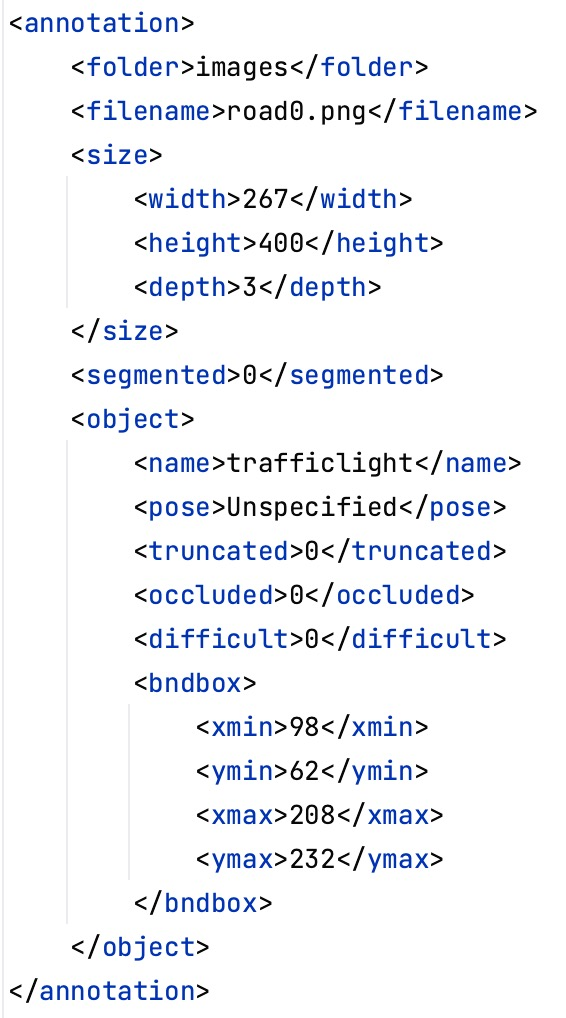

In [16]:
#orignial xml format
Image(filename = "orignial_xml.jpg", width=200, height=100)

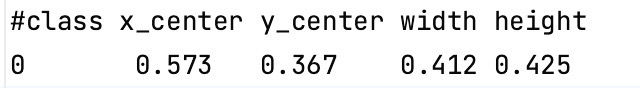

In [17]:
#expected yolo format
Image(filename = "yolo_format.jpg", width=400, height=200 )

In [11]:
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()

    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [14]:
print(extract_info_from_xml('annotations/road4.xml'))

{'bboxes': [{'class': 'trafficlight', 'xmin': 20, 'ymin': 109, 'xmax': 81, 'ymax': 237}, {'class': 'trafficlight', 'xmin': 116, 'ymin': 162, 'xmax': 163, 'ymax': 272}, {'class': 'trafficlight', 'xmin': 189, 'ymin': 189, 'xmax': 233, 'ymax': 295}], 'filename': 'road4.png', 'image_size': (267, 400, 3)}


In [15]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"trafficlight": 0,
                           "stop": 1,
                           "speedlimit": 2,
                           "crosswalk": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
# Get the annotations
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

100%|███████████████████████████████████████| 877/877 [00:00<00:00, 6412.83it/s]


Now we successfully converted the annotations from original xml format to current yolo format, let's randomly pick some image and show the true label

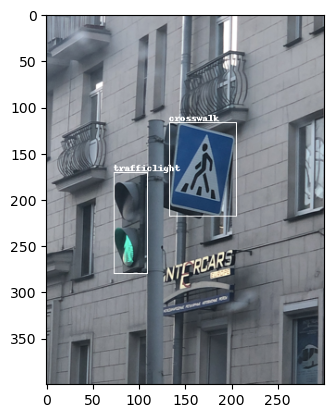

In [ ]:
# check whether the annotation convert worked 
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

### Step 2. Split the dataset

In [ ]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, 
                                                                                annotations, 
                                                                                test_size = 0.2, 
                                                                                random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, 
                                                                              val_annotations, 
                                                                              test_size = 0.5, 
                                                                              random_state = 1)

In [ ]:
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [ ]:
!mv annotations labels
!cd ../yolov5/data

### Step 3. Create our custom data yaml file
To specify the dataset information and directory to images/labels file path<br>
Manually create a .yaml file with info as:

'''<br>
train: ../Road_Sign_Dataset/images/train/ <br>
val:  ../Road_Sign_Dataset/images/val/ <br>
test: ../Road_Sign_Dataset/images/test/ <br>

#number of classes<br>
nc: 4

#class names<br>
names: ["trafficlight","stop", "speedlimit","crosswalk"]<br>
'''

Now let's show our model file's structure, make it clear(will only show the modified/used ones)<br>
ROOT<br>
|--yolov5<br>
&emsp;&emsp;|--data<br>
&emsp;&emsp;&emsp;&emsp;|--coco.yaml (the original dataset for reproduce)<br>
&emsp;&emsp;&emsp;&emsp;|--VOC.yaml (one provided dataset, will also use this to train)<br>
&emsp;&emsp;&emsp;&emsp;|--road_sign.yaml (uploaded, our custom dataset)<br>
&emsp;&emsp;|--models<br>
&emsp;&emsp;&emsp;&emsp;|--yolov5n.yaml (creates the model structure)<br>
&emsp;&emsp;&emsp;&emsp;|--yolo.py (modify and fine-tuning)<br>
&emsp;&emsp;|--runs<br>
&emsp;&emsp;&emsp;&emsp;|--train (training result)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;|--expXX (training task)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;|--weights<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;|--best.pt (best result of trained parameter weights)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;|--last.pt (final result of trained parameter weights)<br>
&emsp;&emsp;&emsp;&emsp;|--detect (inference result)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;|--expXX (inference task)<br>
&emsp;&emsp;|--detect.py<br>
&emsp;&emsp;|--train.py<br>
|--datasets<br>
&emsp;&emsp;|--coco<br>
&emsp;&emsp;|--road_sign<br>
&emsp;&emsp;|--VOC<br>

## Training our Custom Dataset - Road Sign

Tensorboard can be used to streamingly visualize the training process<br>

In [19]:
!pip install -q tf-nightly-2.0-preview
# Load the TensorBoard notebook extension
%load_ext tensorboard

Given that our road_sign dataset comprises approximately 800 images, and we plan to initiate our training using pretrained weights, we anticipate that the model will converge relatively easily. We'll commence with a training plan of 50 epochs to evaluate the effectiveness and observe the outcomes. This approach should provide a solid starting point for fine-tuning and optimizing the detection capabilities of our model on this specialized dataset.

In [ ]:
!python train.py --img 640 --cfg yolov5n.yaml --batch-size 16 --epochs 50 --data road_sign.yaml --weights yolov5n.pt --workers 6 --cache --name yolo_road_default

train: weights=yolov5n.pt, cfg=yolov5n.yaml, data=road_sign.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=6, project=runs\train, name=yolo_road_default, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github:  YOLOv5 is out of date by 1 commit. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5  v7.0-296-gae4ef3b2 Python-3.10.14 torch-2.0.0 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16379MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.000

Let's take a look over the training process:

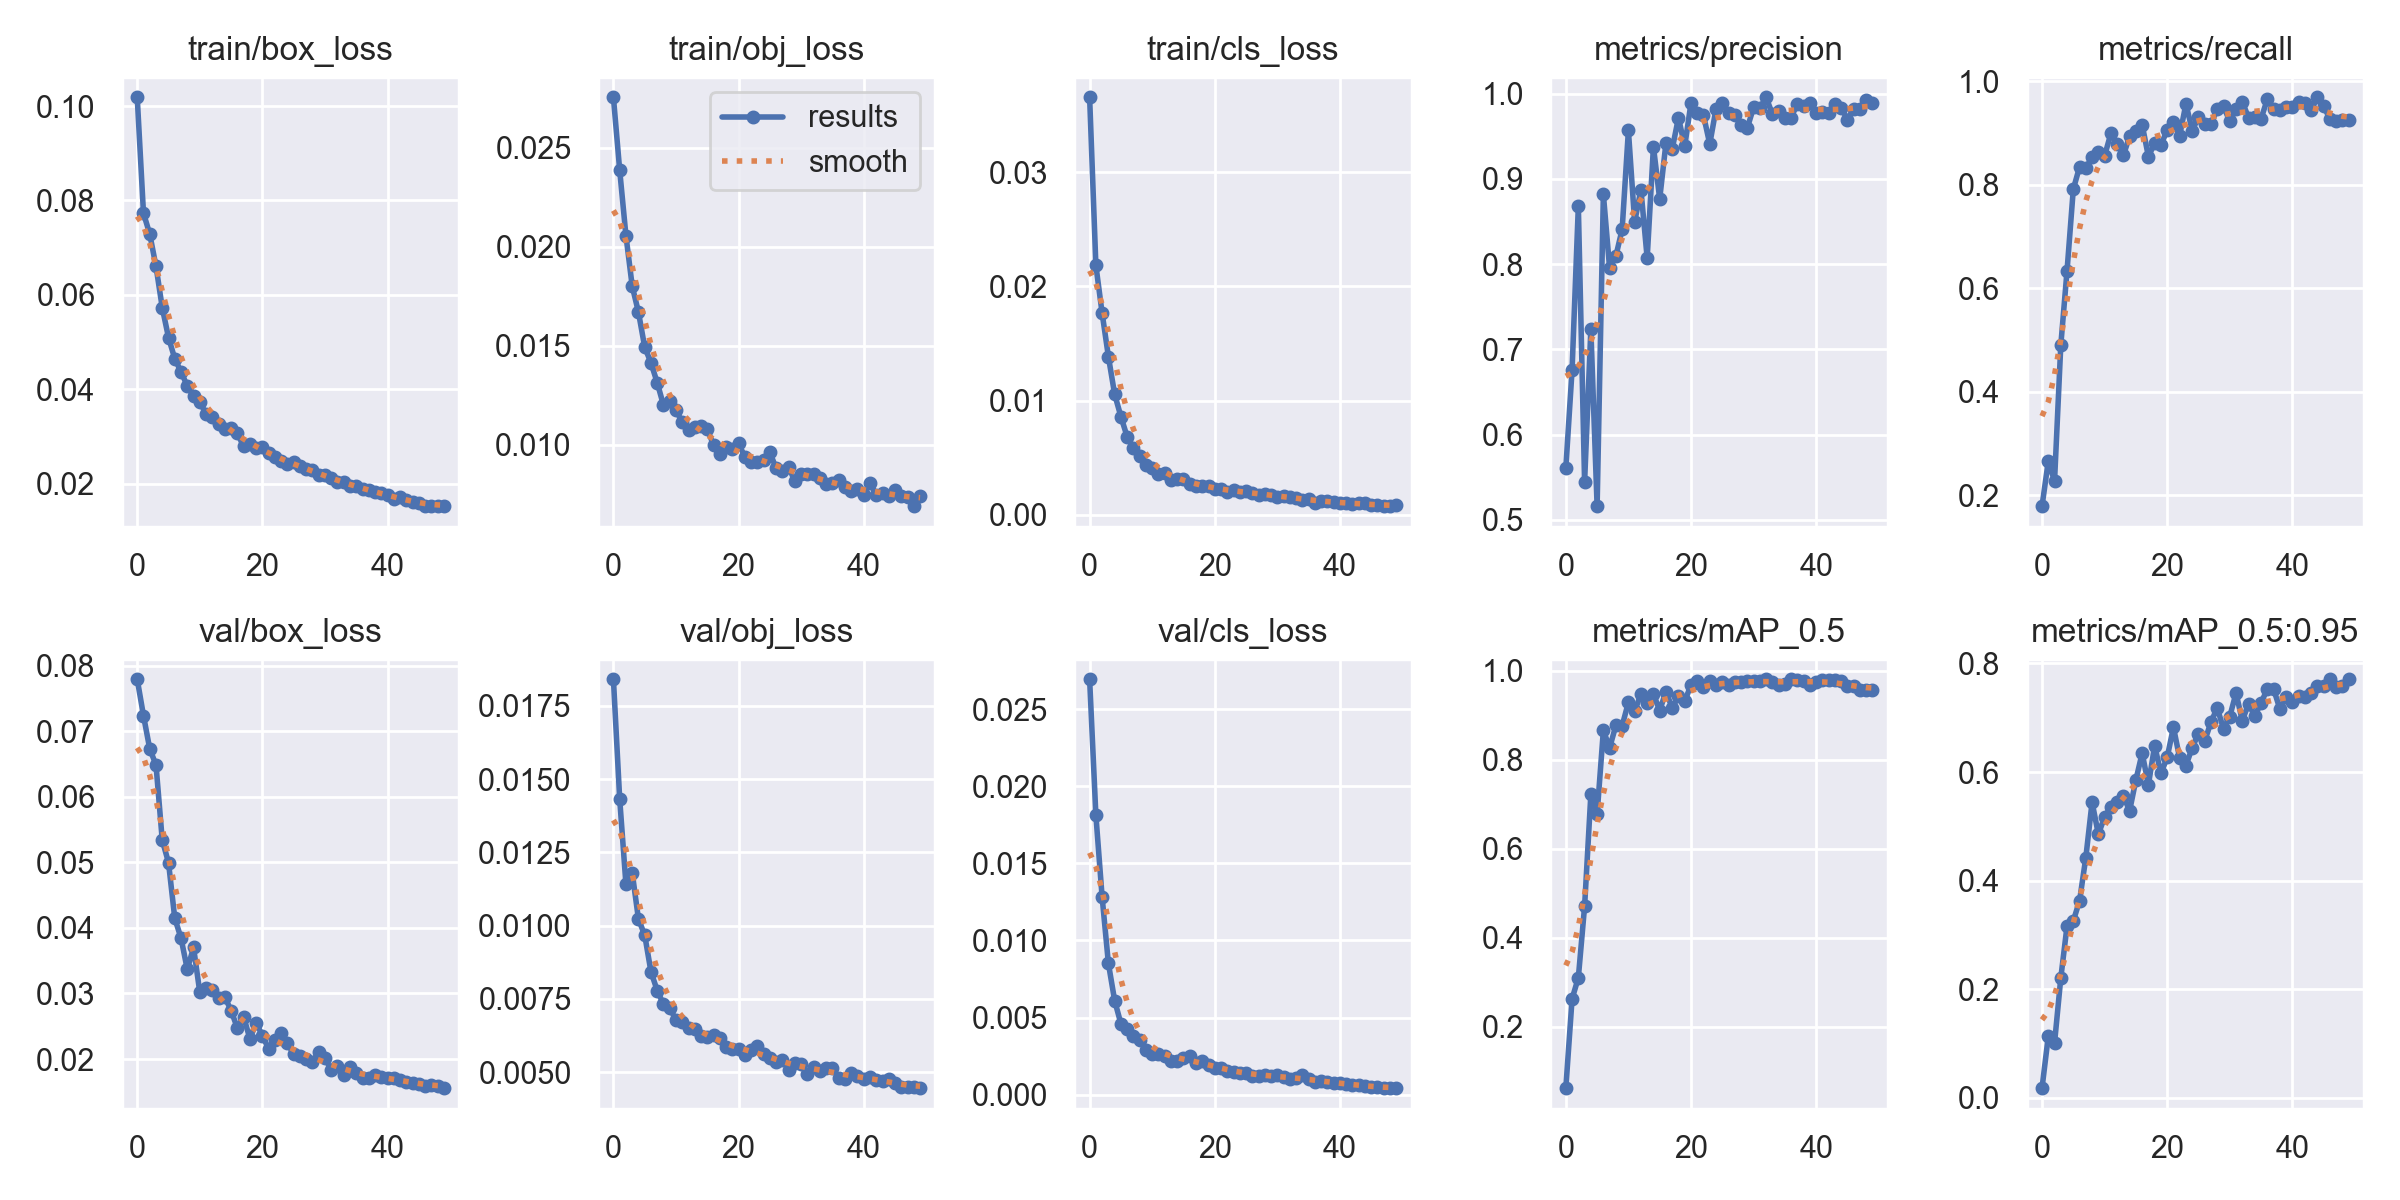

In [42]:
Image(filename = 'runs/train/yolo_road_default/results.png')

Observations:


1. There is a smooth convergence for both losses and performance metrics, with no signs of overfitting, as the validation losses follow the training losses downward without a significant gap.<br>
2. The plateauing of the curves, especially in the validation losses and the mAP metrics, suggests that the model is nearing its optimal performance given the current architecture and hyperparameter setup.<br>
3. The smoothness in the curves indicates a stable training process without much noise, which is often a sign of a well-tuned learning rate and batch size.<br>
4. The consistency between the training and validation loss curves indicates that the model generalizes well to unseen data.<br>

Let's take a look over the validation with the best weights the model found during training

In [ ]:
!python val.py --weights runs/train/yolo_road_default/weights/best.pt --data road_sign.yaml --img 640 --batch-size 16 --workers 6 --name road_sign_default

val: data=C:\Users\amaris-admin\Documents\yolov5\data\road_sign.yaml, weights=['runs/train/yolo_road_default/weights/best.pt'], batch_size=16, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=6, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name=road_sign_default, exist_ok=False, half=False, dnn=False
YOLOv5  v7.0-296-gae4ef3b2 Python-3.10.14 torch-2.0.0 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16379MiB)

Fusing layers... 
YOLOv5n summary: 157 layers, 1764577 parameters, 0 gradients, 4.1 GFLOPs

val: Scanning C:\Users\amaris-admin\Documents\datasets\road_sign_dataset\labels\val.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
val: Scanning C:\Users\amaris-admin\Documents\datasets\road_sign_dataset\labels\val.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]

                 Class     Images  Inst

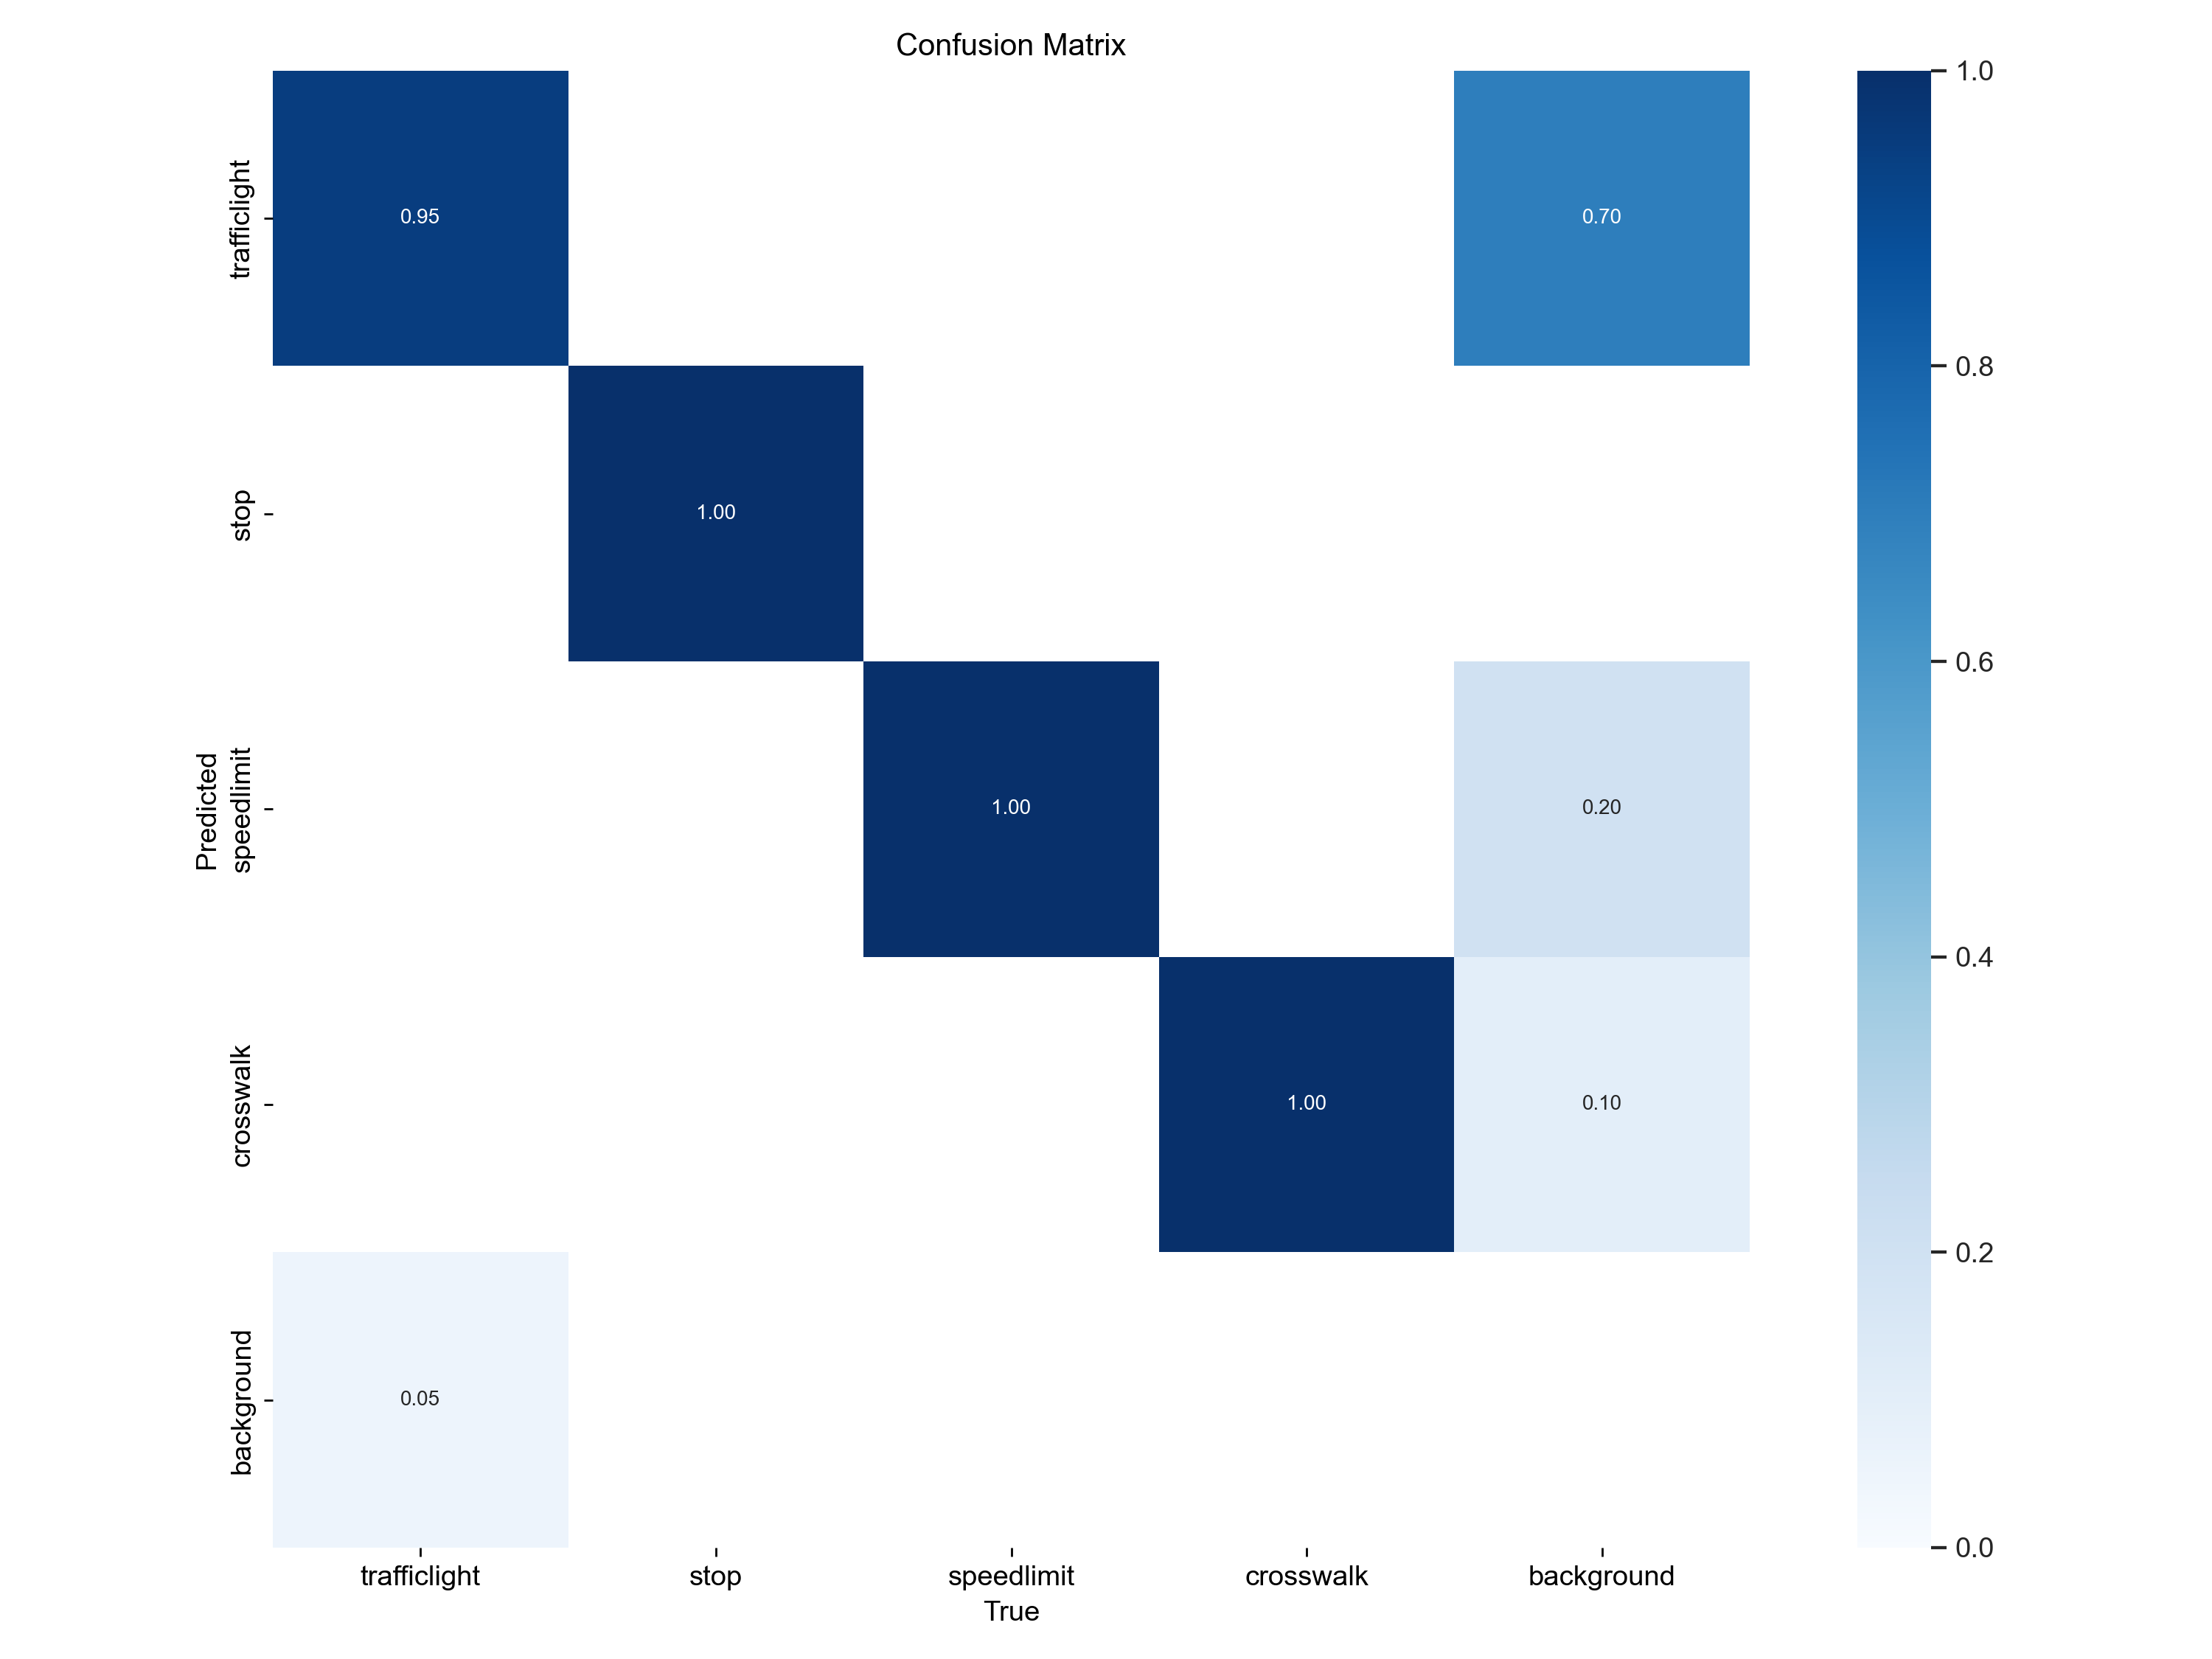

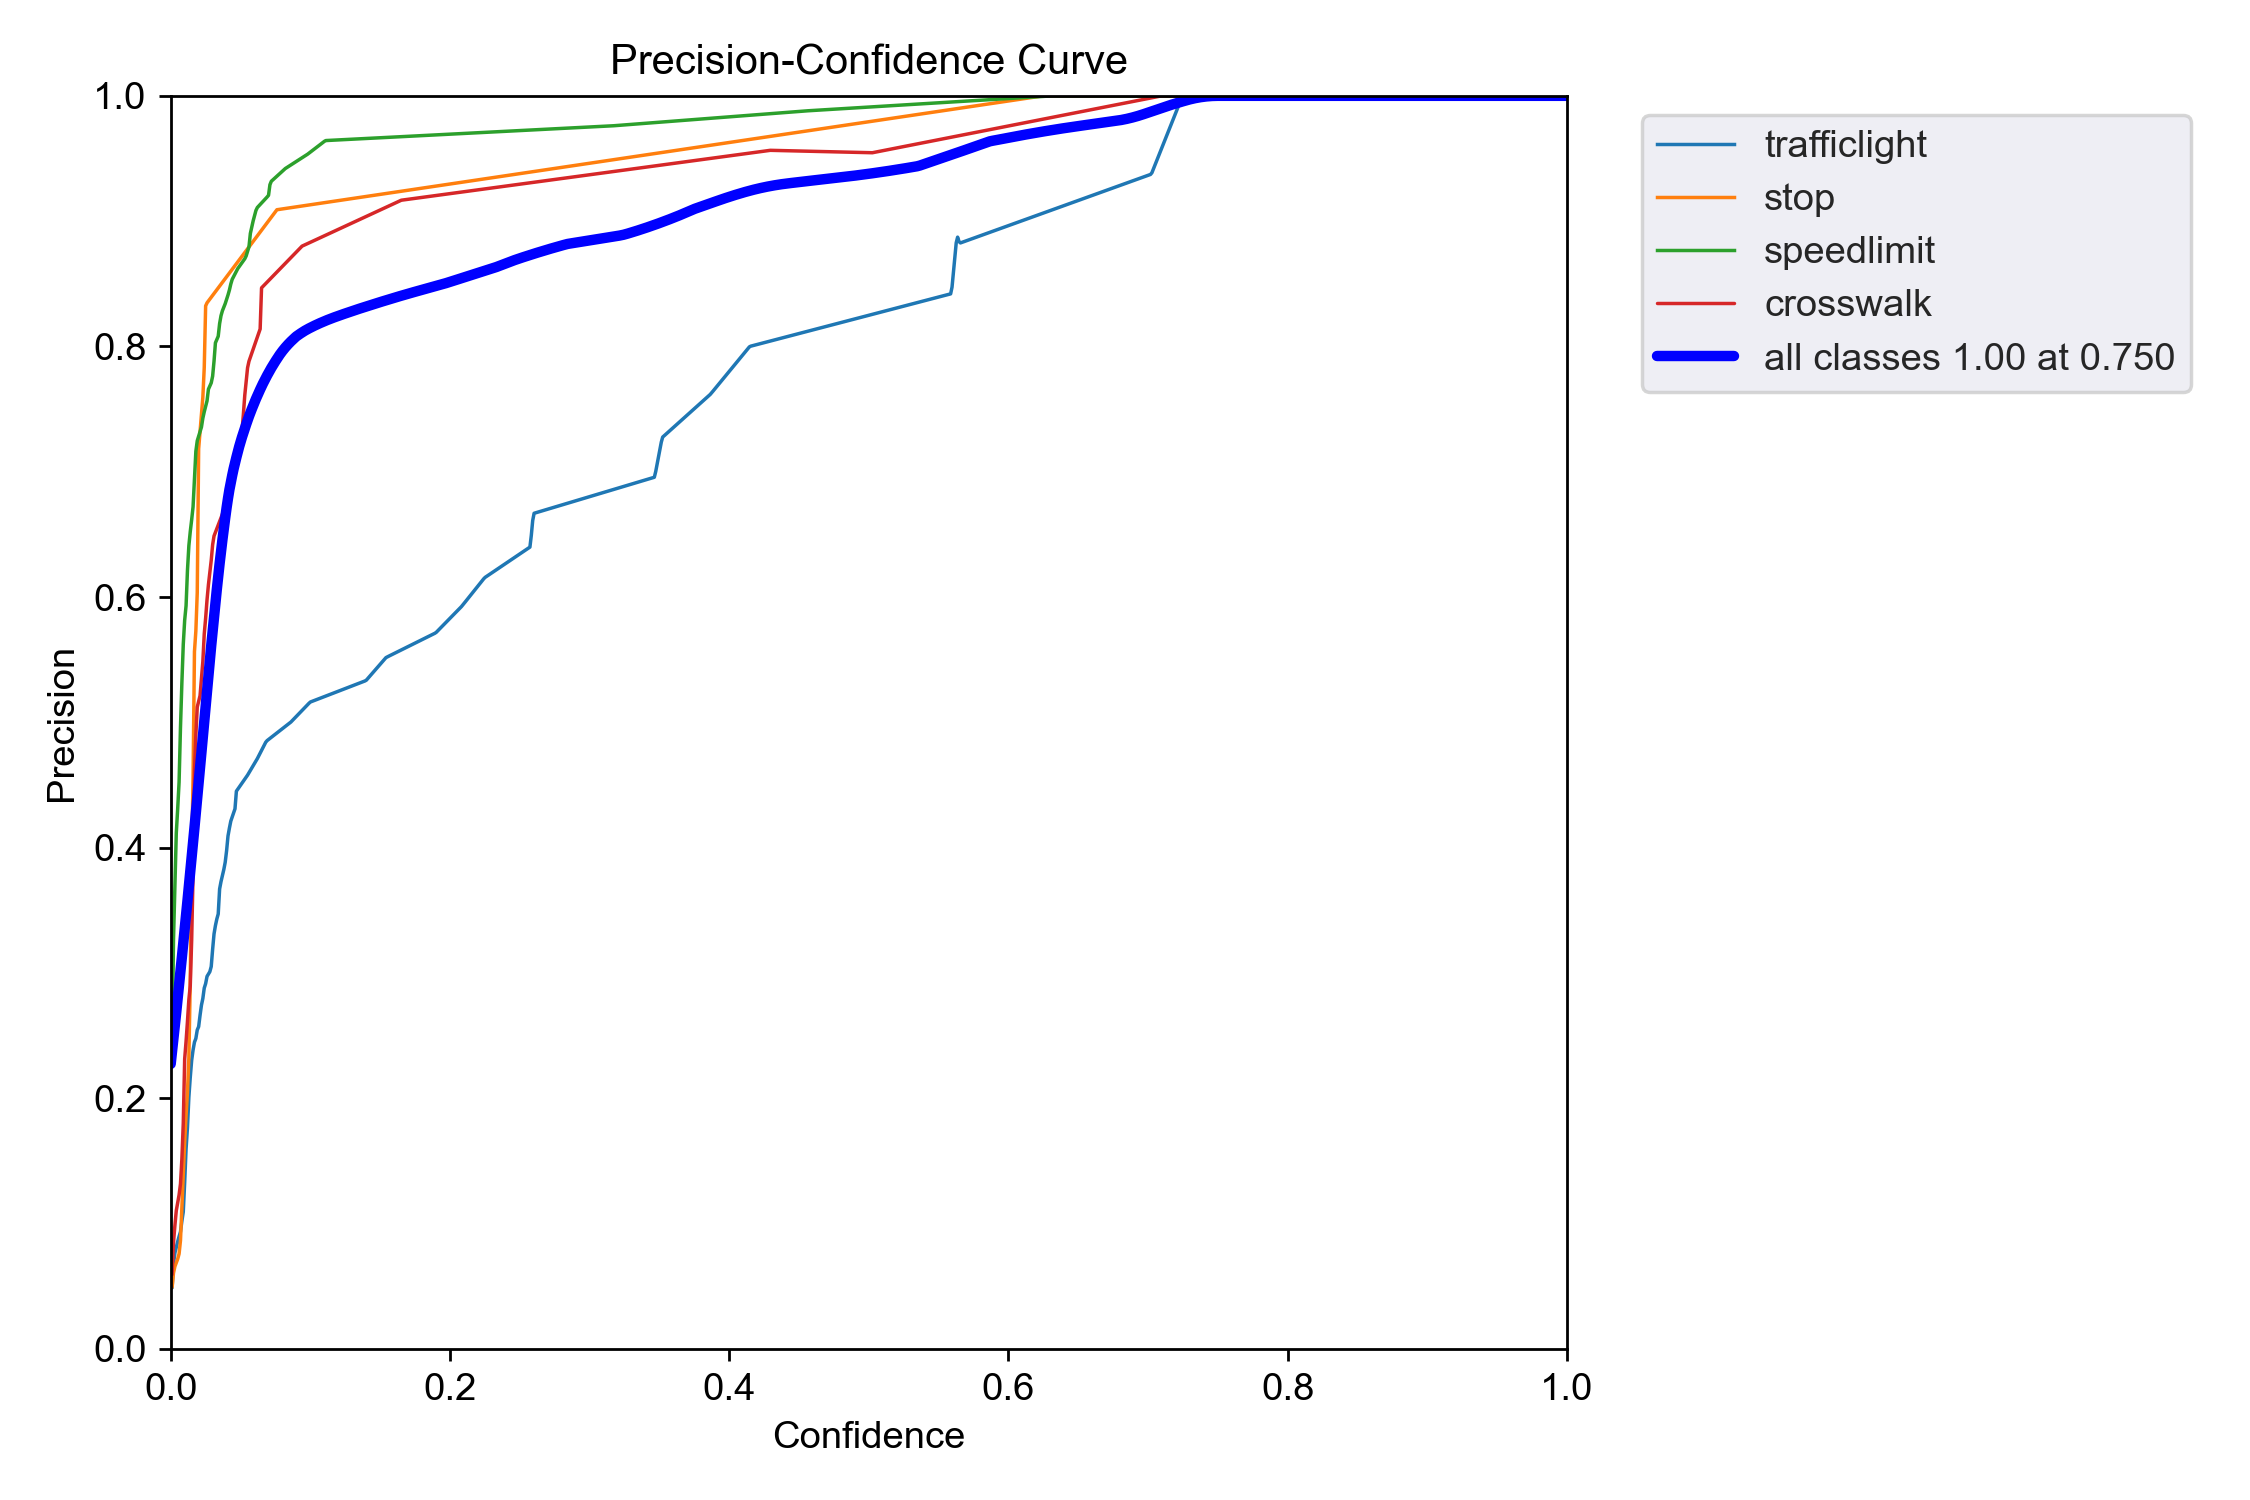

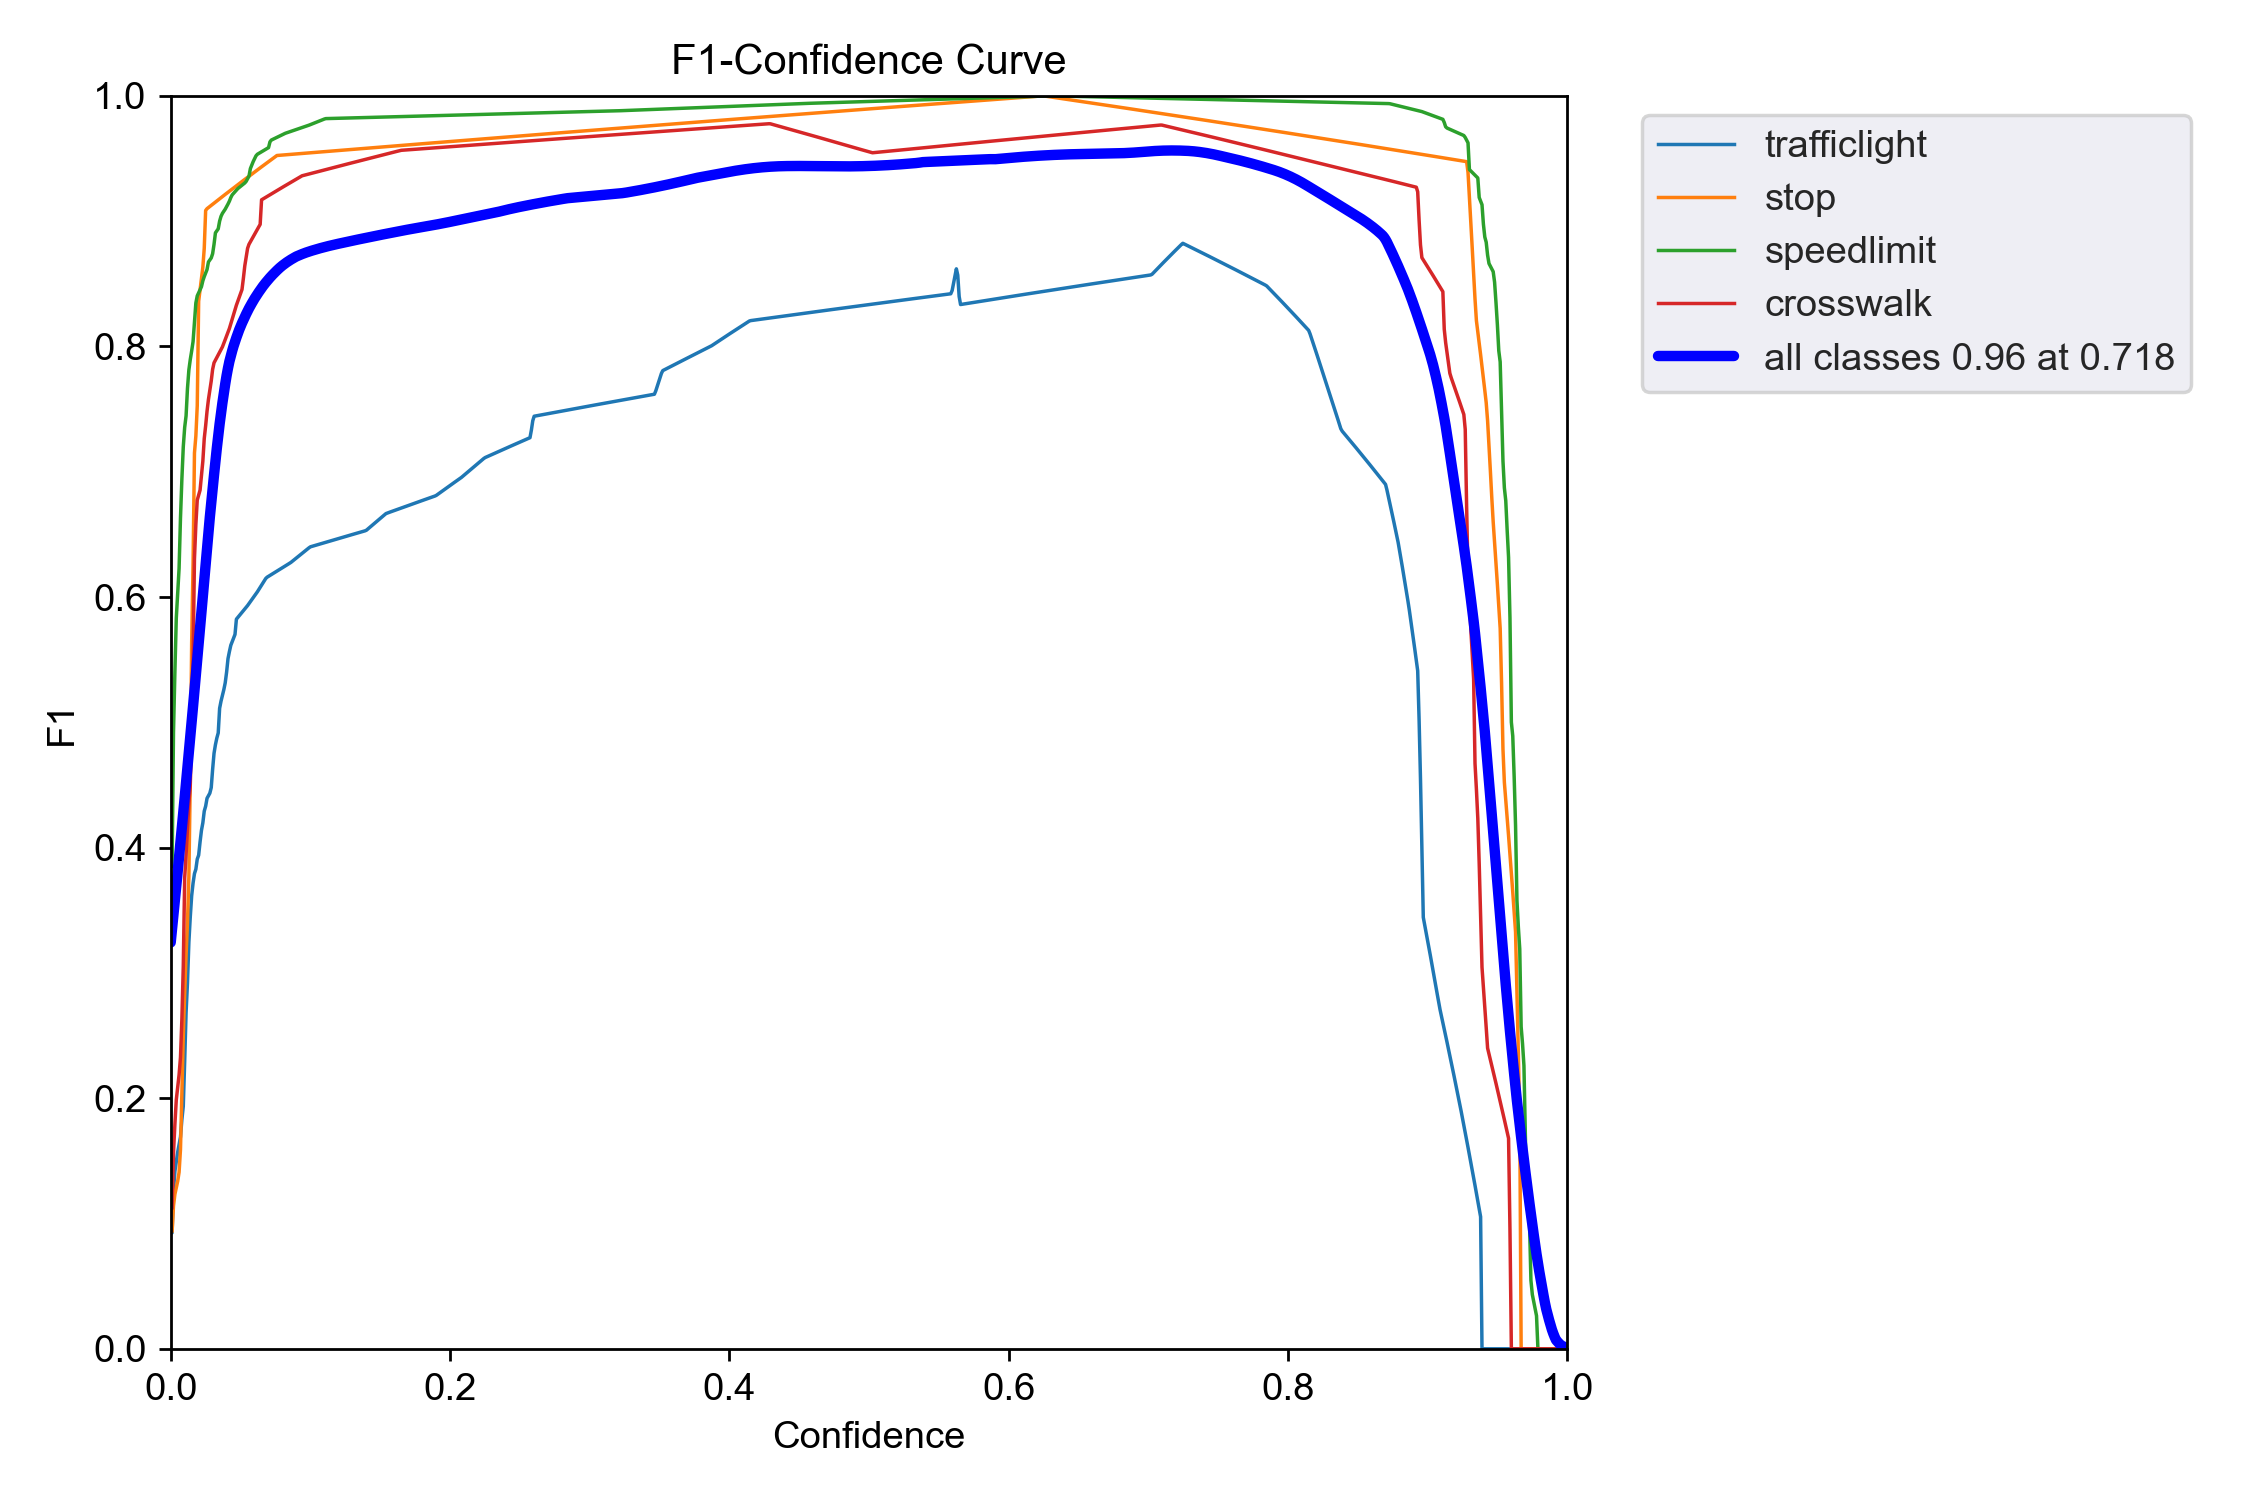

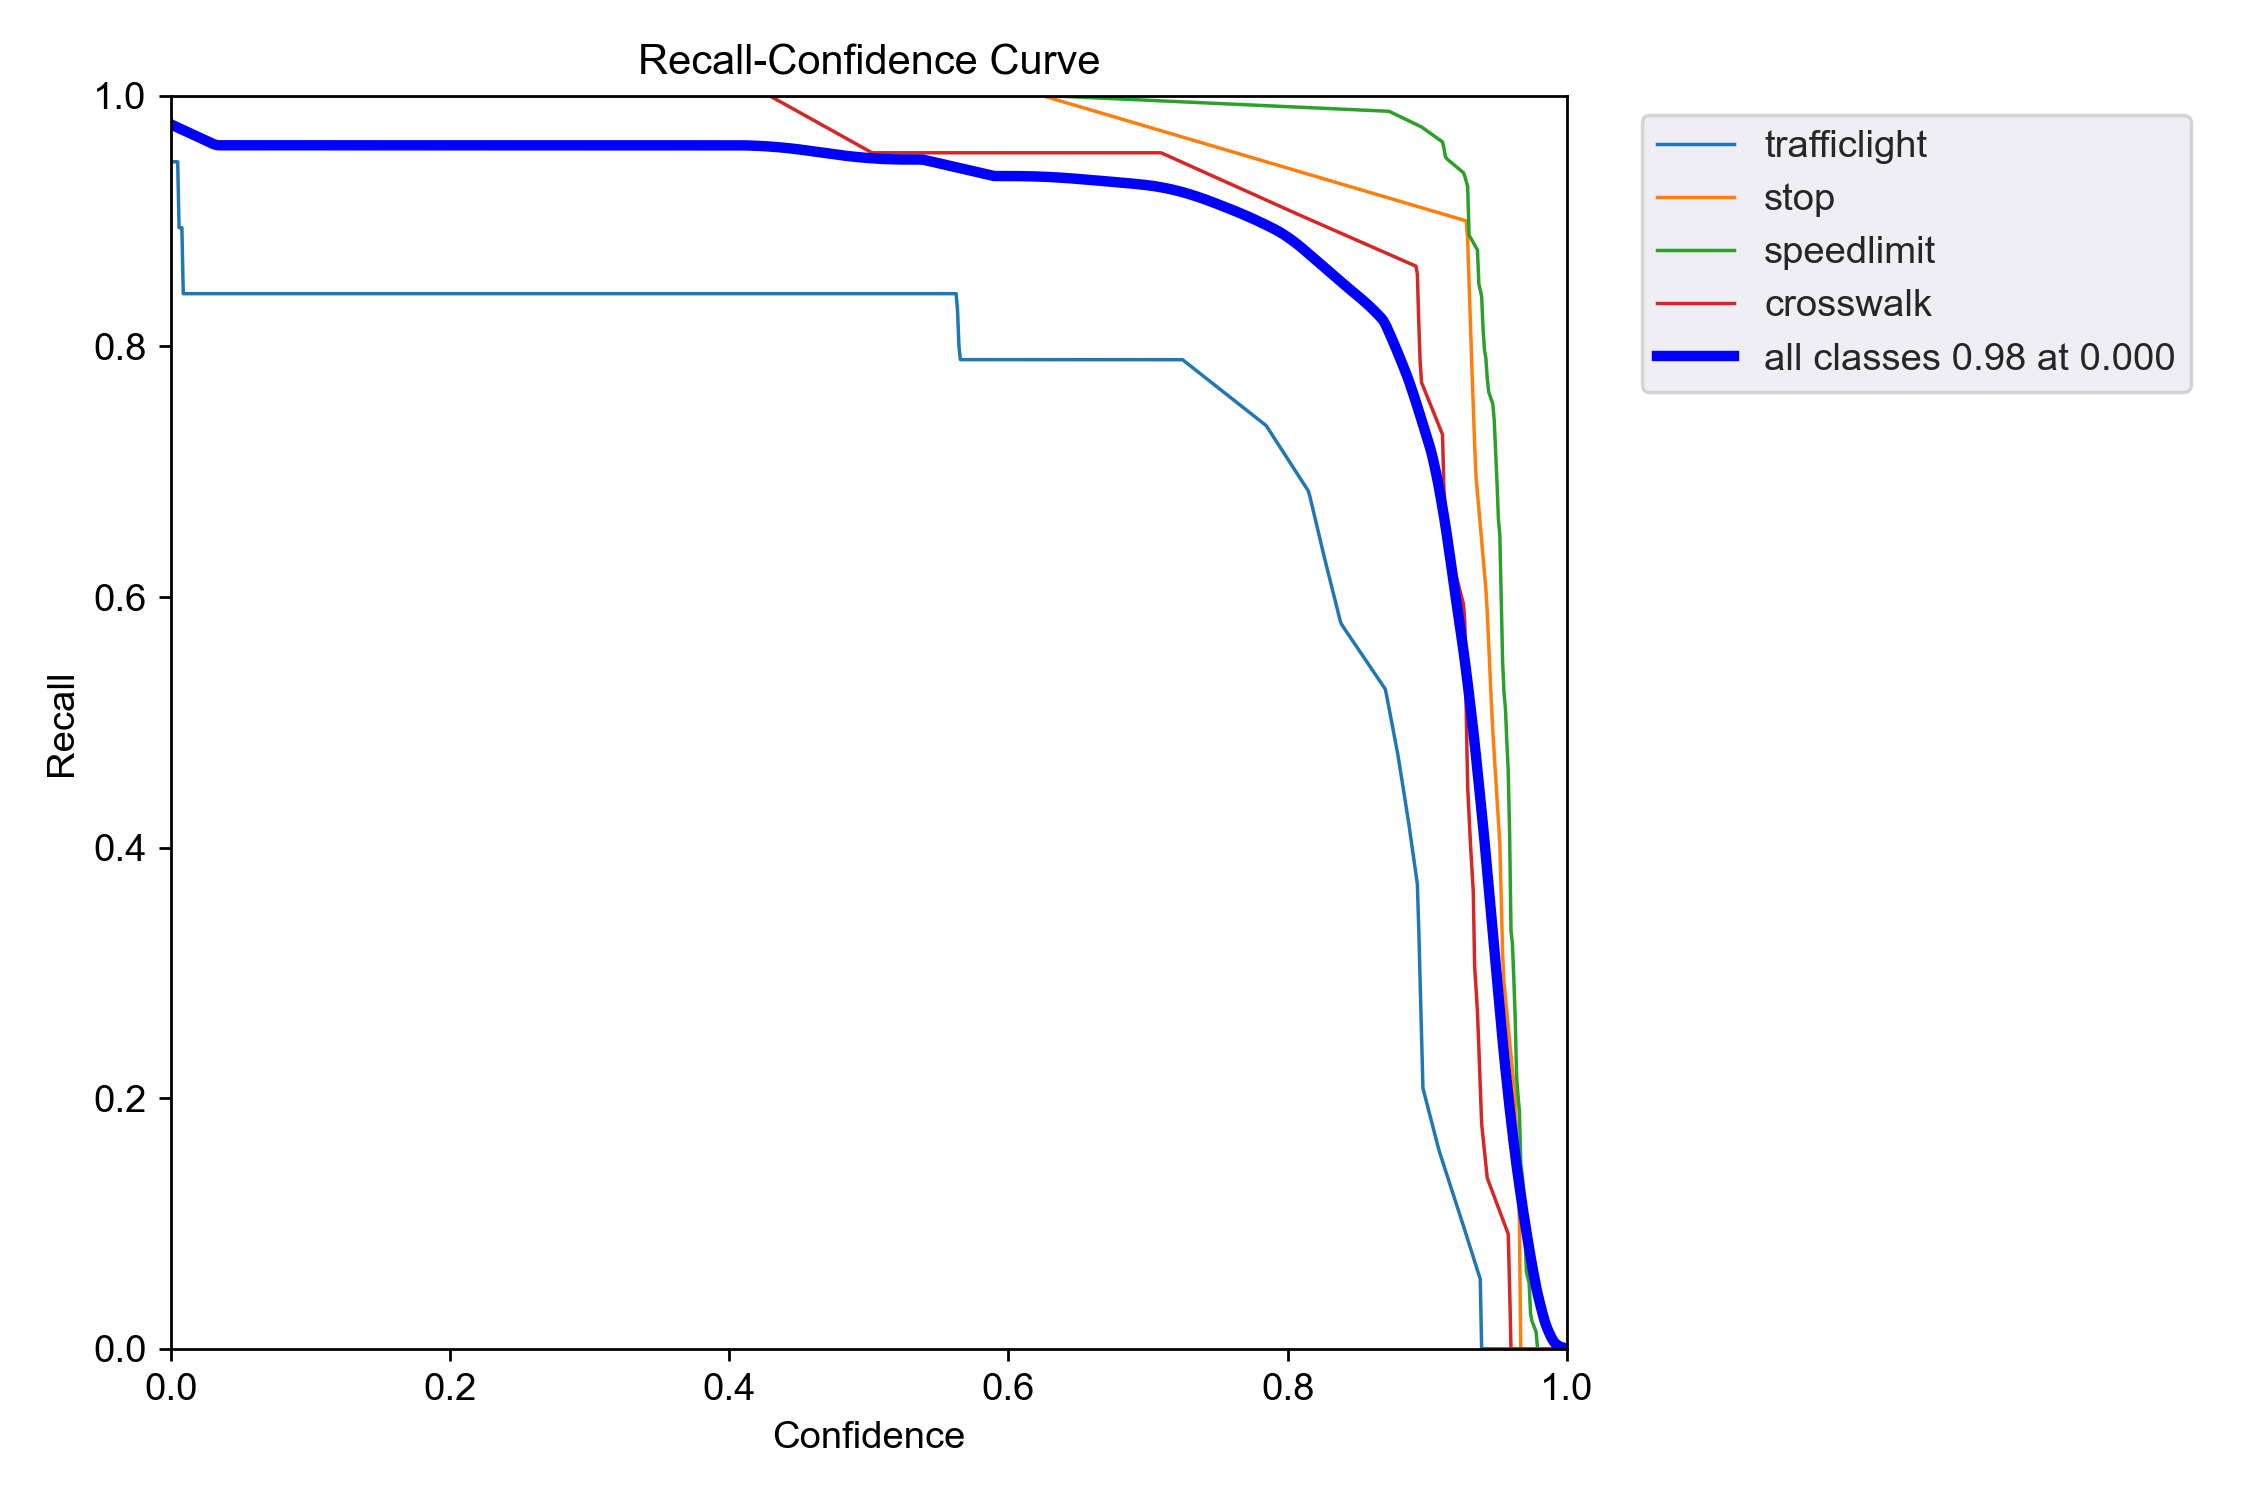

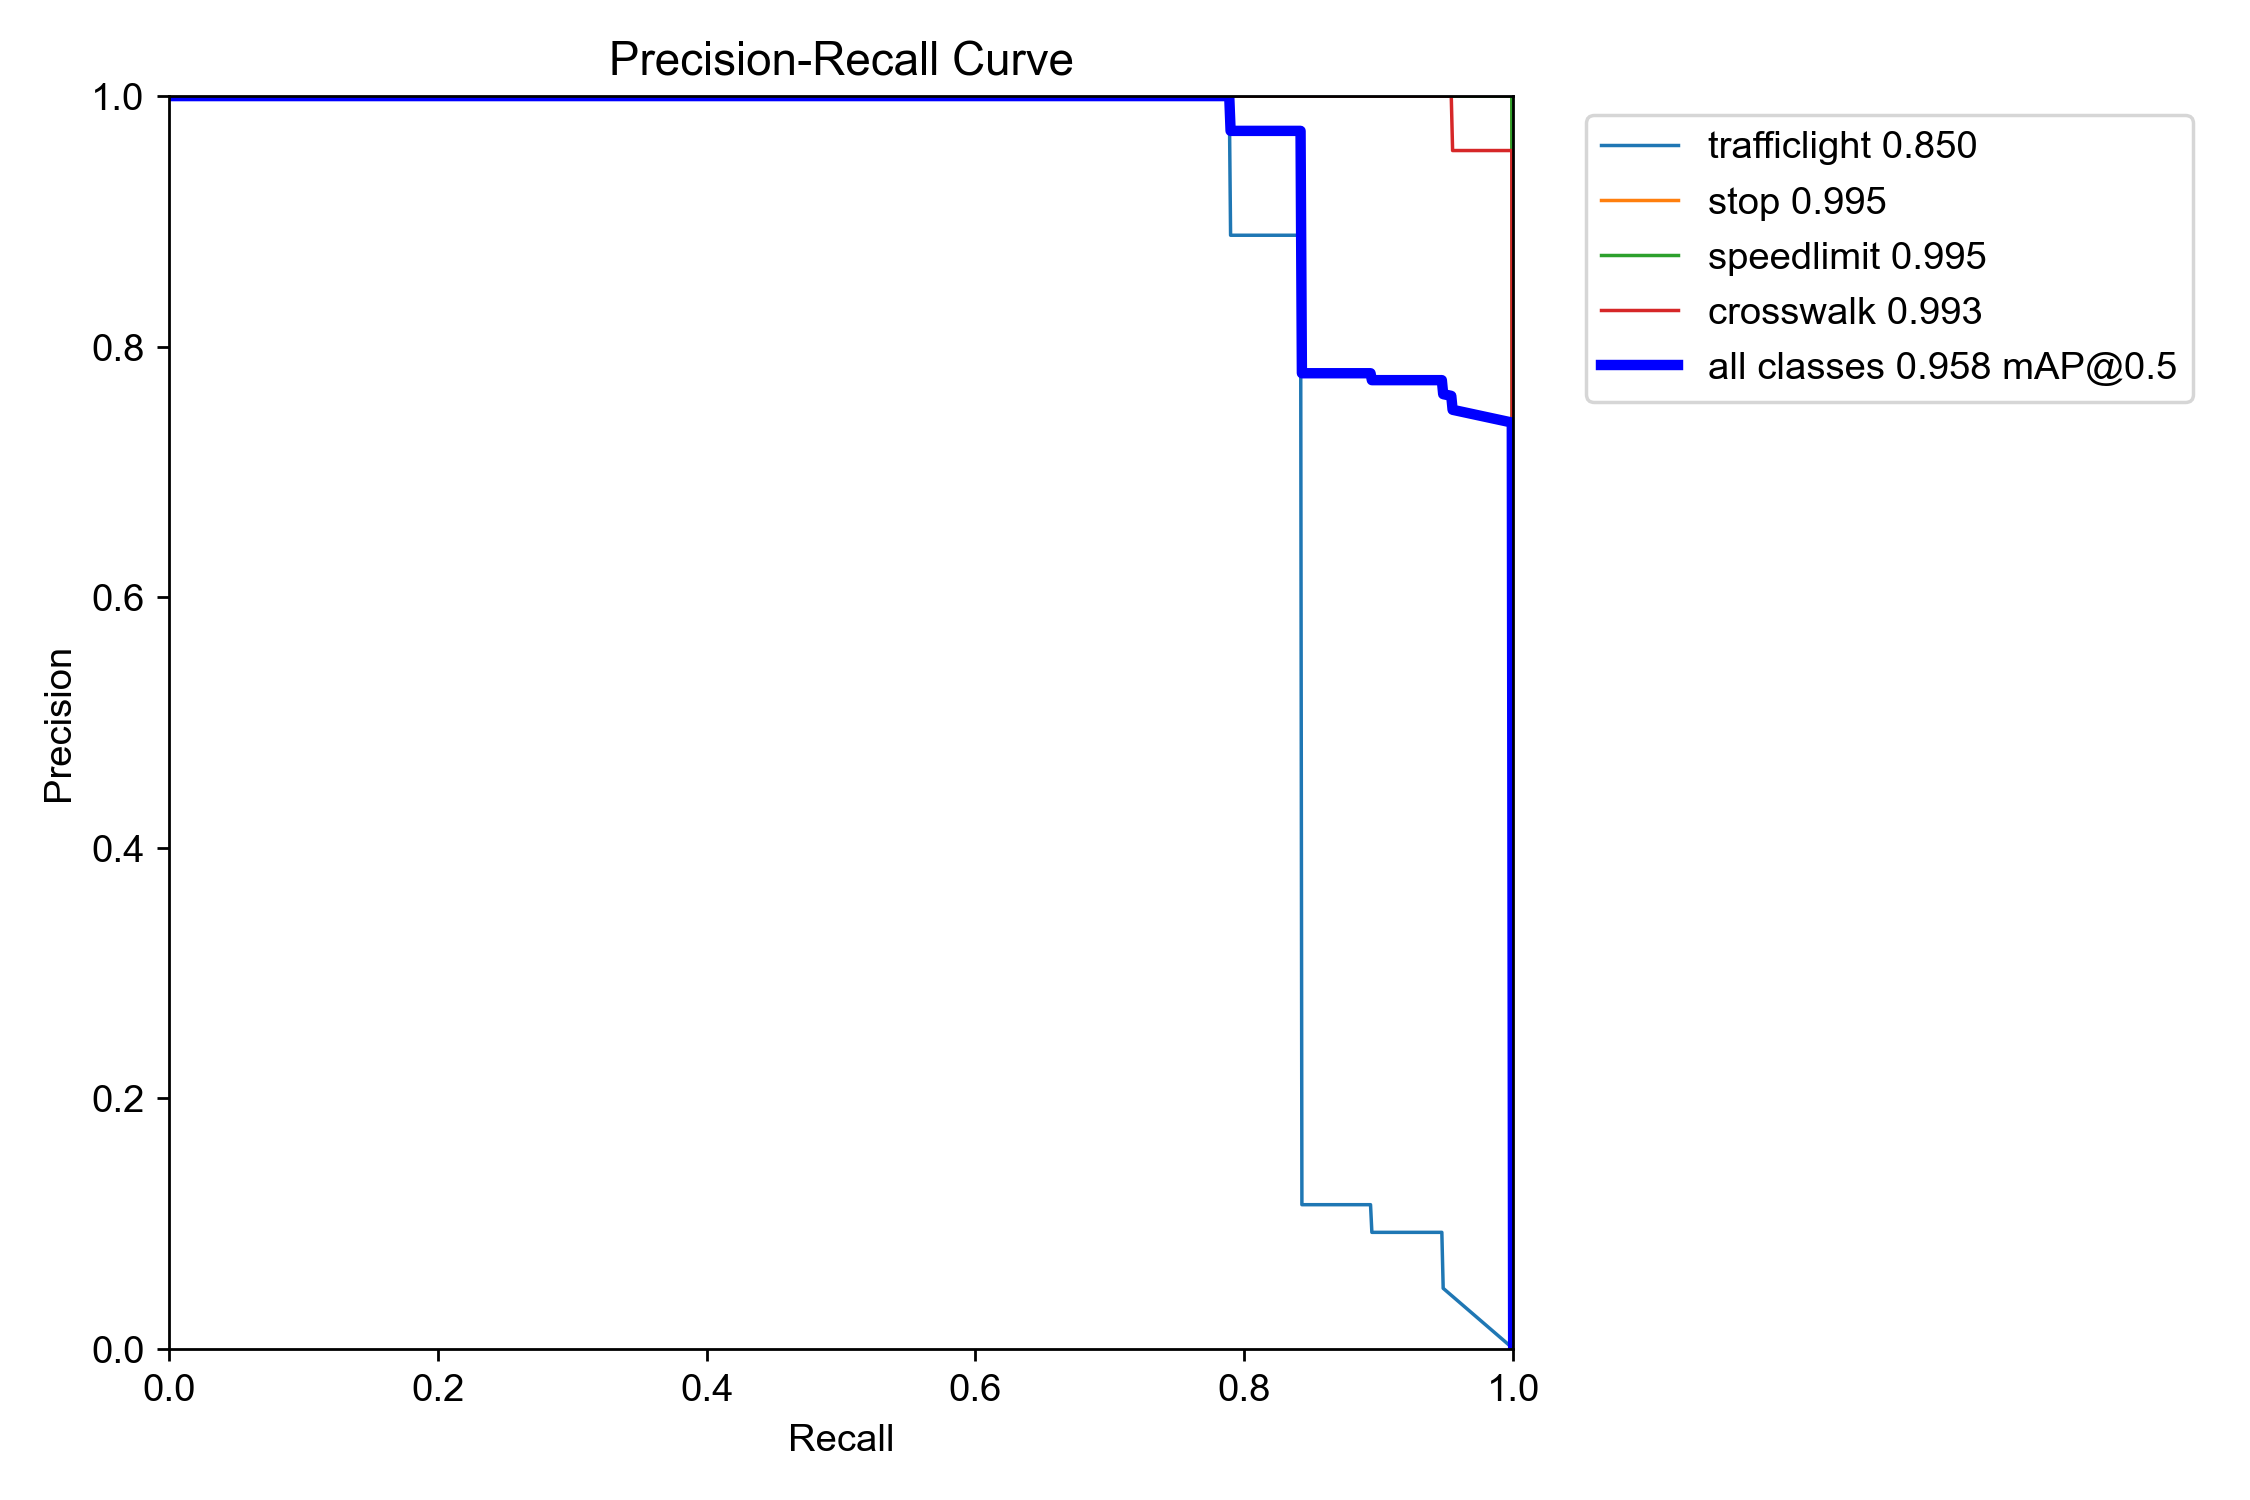

In [54]:
current_directory = os.getcwd()
val_directory = 'runs/val/road_sign_default'

path = os.path.join(current_directory, val_directory)

# Automatically get all .png files in the directory
png_files = [file for file in os.listdir(path) if file.endswith('.png')]

# Display each image
for image in png_files:
    display(Image(filename=os.path.join(path, image)))

## hyper-parameter tuning

Now, let's do some hyper-parameter training, to see whether our model can achieve a better performance with current 50 epoches used, ideas:
1. increase the initial learning rate to 0.02, since we working on a small dataset
2. increase the warmup epochs to 5, to prevent the unstable issue at the beginning
3. increase the box loss gain to 0.1, 
some data augmentation necessary for our small dataset:
4. increased hsv_h (HSV-Hue) to 0.05, increase the robustness to lighting and color change
5. increase translate to 0.2 and scale to 0.6, help model to catch more about position and size change

In [11]:
!python train.py --hyp data/hyps/hyp.test_tune.yaml --cfg yolov5n.yaml --batch-size -1 --epochs 50 --data road_sign.yaml --weights yolov5n.pt --workers 6 --cache --name yolo_road_hyp

train: weights=yolov5n.pt, cfg=yolov5n.yaml, data=road_sign.yaml, hyp=data/hyps/hyp.test_tune.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=6, project=runs\train, name=yolo_road_hyp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github:  YOLOv5 is out of date by 1 commit. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5  v7.0-296-gae4ef3b2 Python-3.10.14 torch-2.0.0 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16379MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, war

Observations: 

1. The slight performance drop post-tuning, especially in the mAP50-95 scores, could suggest  less effective hyperparameters, or that the model had already been close to optimal settings before the tuning. 
2. The difference in performance is relatively small, which may imply that the hyperparameter space around the pre-tuning values was already well-optimized for this particular dataset and task.
3. It's also possible that the dataset's size and complexity limit the performance gains from further hyperparameter tuning.

So, let's turn to train with a much larger dataset, VOC dataset:

## VOC dataset
VOC dataset, specifically the PASCAL Visual Object Classes (VOC) dataset, contains ~20k images with 20 classes.

The 20 classes in the PASCAL VOC dataset are as follows:

Person: person<br>
Animals: bird, cat, cow, dog, horse, sheep<br>
Vehicles: aeroplane, bicycle, boat, bus, car, motorbike, train<br>
Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor<br>

This time we will only run for 30 epochs and the training process takes up to 3 hours:

In [8]:
!python train.py --hyp data/hyps/hyp.scratch-low.yaml --cfg yolov5n.yaml --batch-size -1 --epochs 30 --data VOC.yaml --weights yolov5n.pt --workers 1 --cache --name VOC_default

      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     1790977       4.306         0.365         19.92         57.98        (1, 3, 640, 640)                    list
     1790977       8.612         0.403         15.67         30.83        (2, 3, 640, 640)                    list
     1790977       17.22         0.646         14.67         26.84        (4, 3, 640, 640)                    list
     1790977       34.45         0.891         14.33         29.43        (8, 3, 640, 640)                    list
     1790977       68.89         1.629            20         33.91       (16, 3, 640, 640)                    list


train: weights=yolov5n.pt, cfg=yolov5n.yaml, data=VOC.yaml, hyp=data/hyps/hyp.scratch-high.yaml, epochs=30, batch_size=-1, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=1, project=runs\train, name=VOC_hyp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github:  YOLOv5 is out of date by 1 commit. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5  v7.0-296-gae4ef3b2 Python-3.10.14 torch-2.0.0 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16379MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs

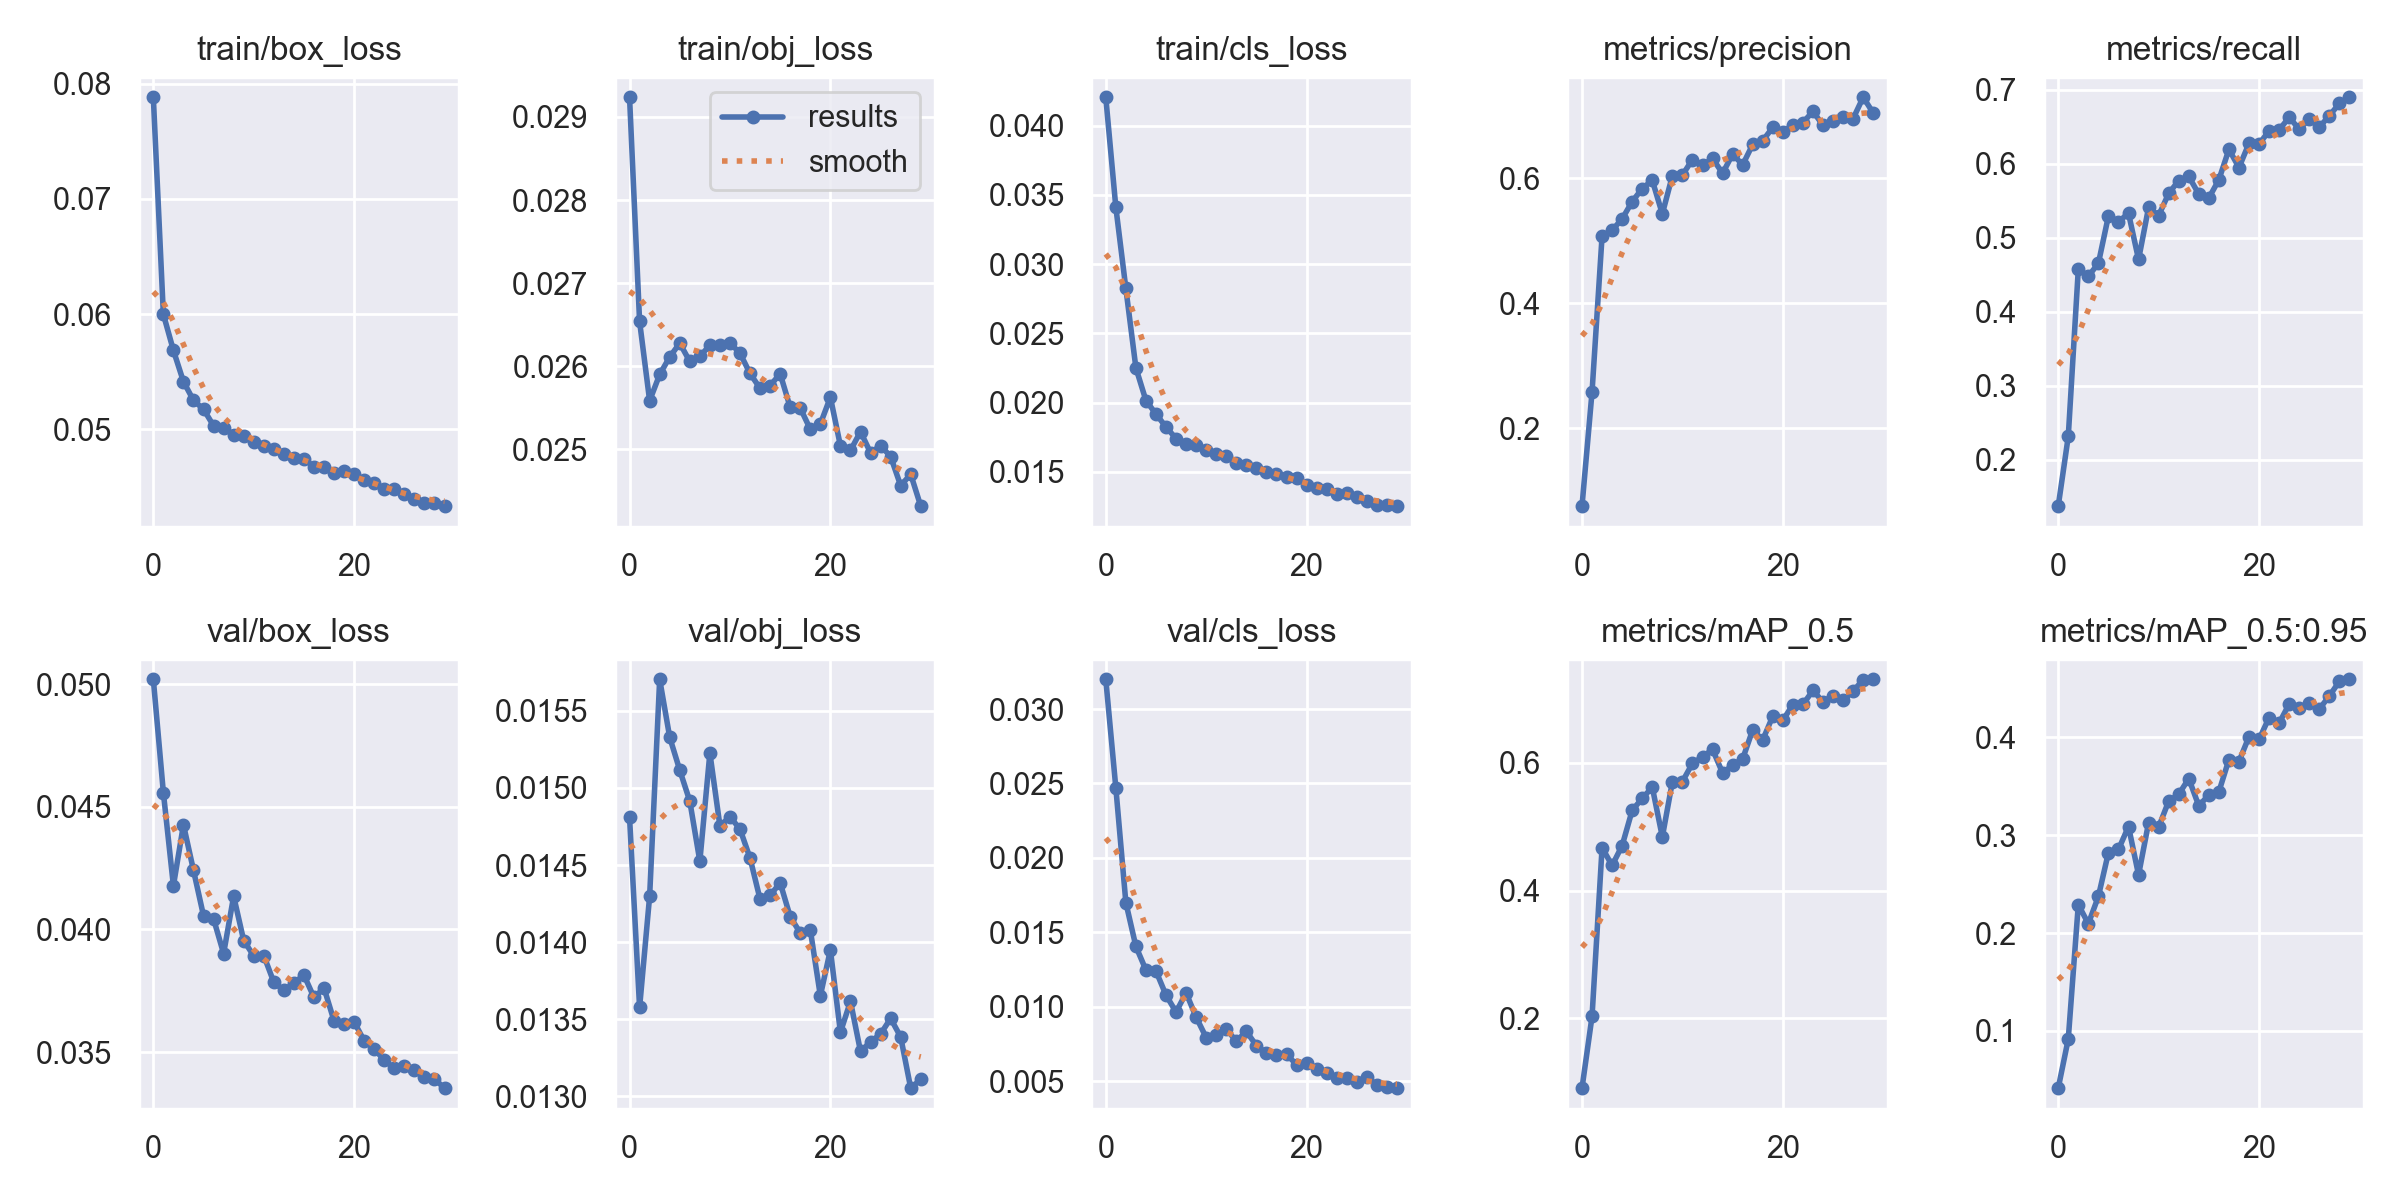

In [55]:
HyImage(filename = 'runs/train/VOC_default/results.png')

## Hyper-parameter Tuning
For this more complex dataset, we can see that our model have not reached the optimal solution yet, so for this hyper-parameter tuning section, we decided to do the following:
1. increased the BCEloss weights to make the model learning process more radical
2. slightly decrease the initial learning rate to aviod potiential overfit

In [4]:
w!python train.py --cfg yolov5n.yaml --batch-size 128 --epochs 30 --data VOC.yaml --weights yolov5n.pt --workers 1 --cache --name VOC_default

train: weights=yolov5n.pt, cfg=yolov5n.yaml, data=VOC.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=30, batch_size=128, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=1, project=runs\train, name=VOC_default, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github:  YOLOv5 is out of date by 1 commit. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5  v7.0-296-gae4ef3b2 Python-3.10.14 torch-2.0.0 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16379MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_e

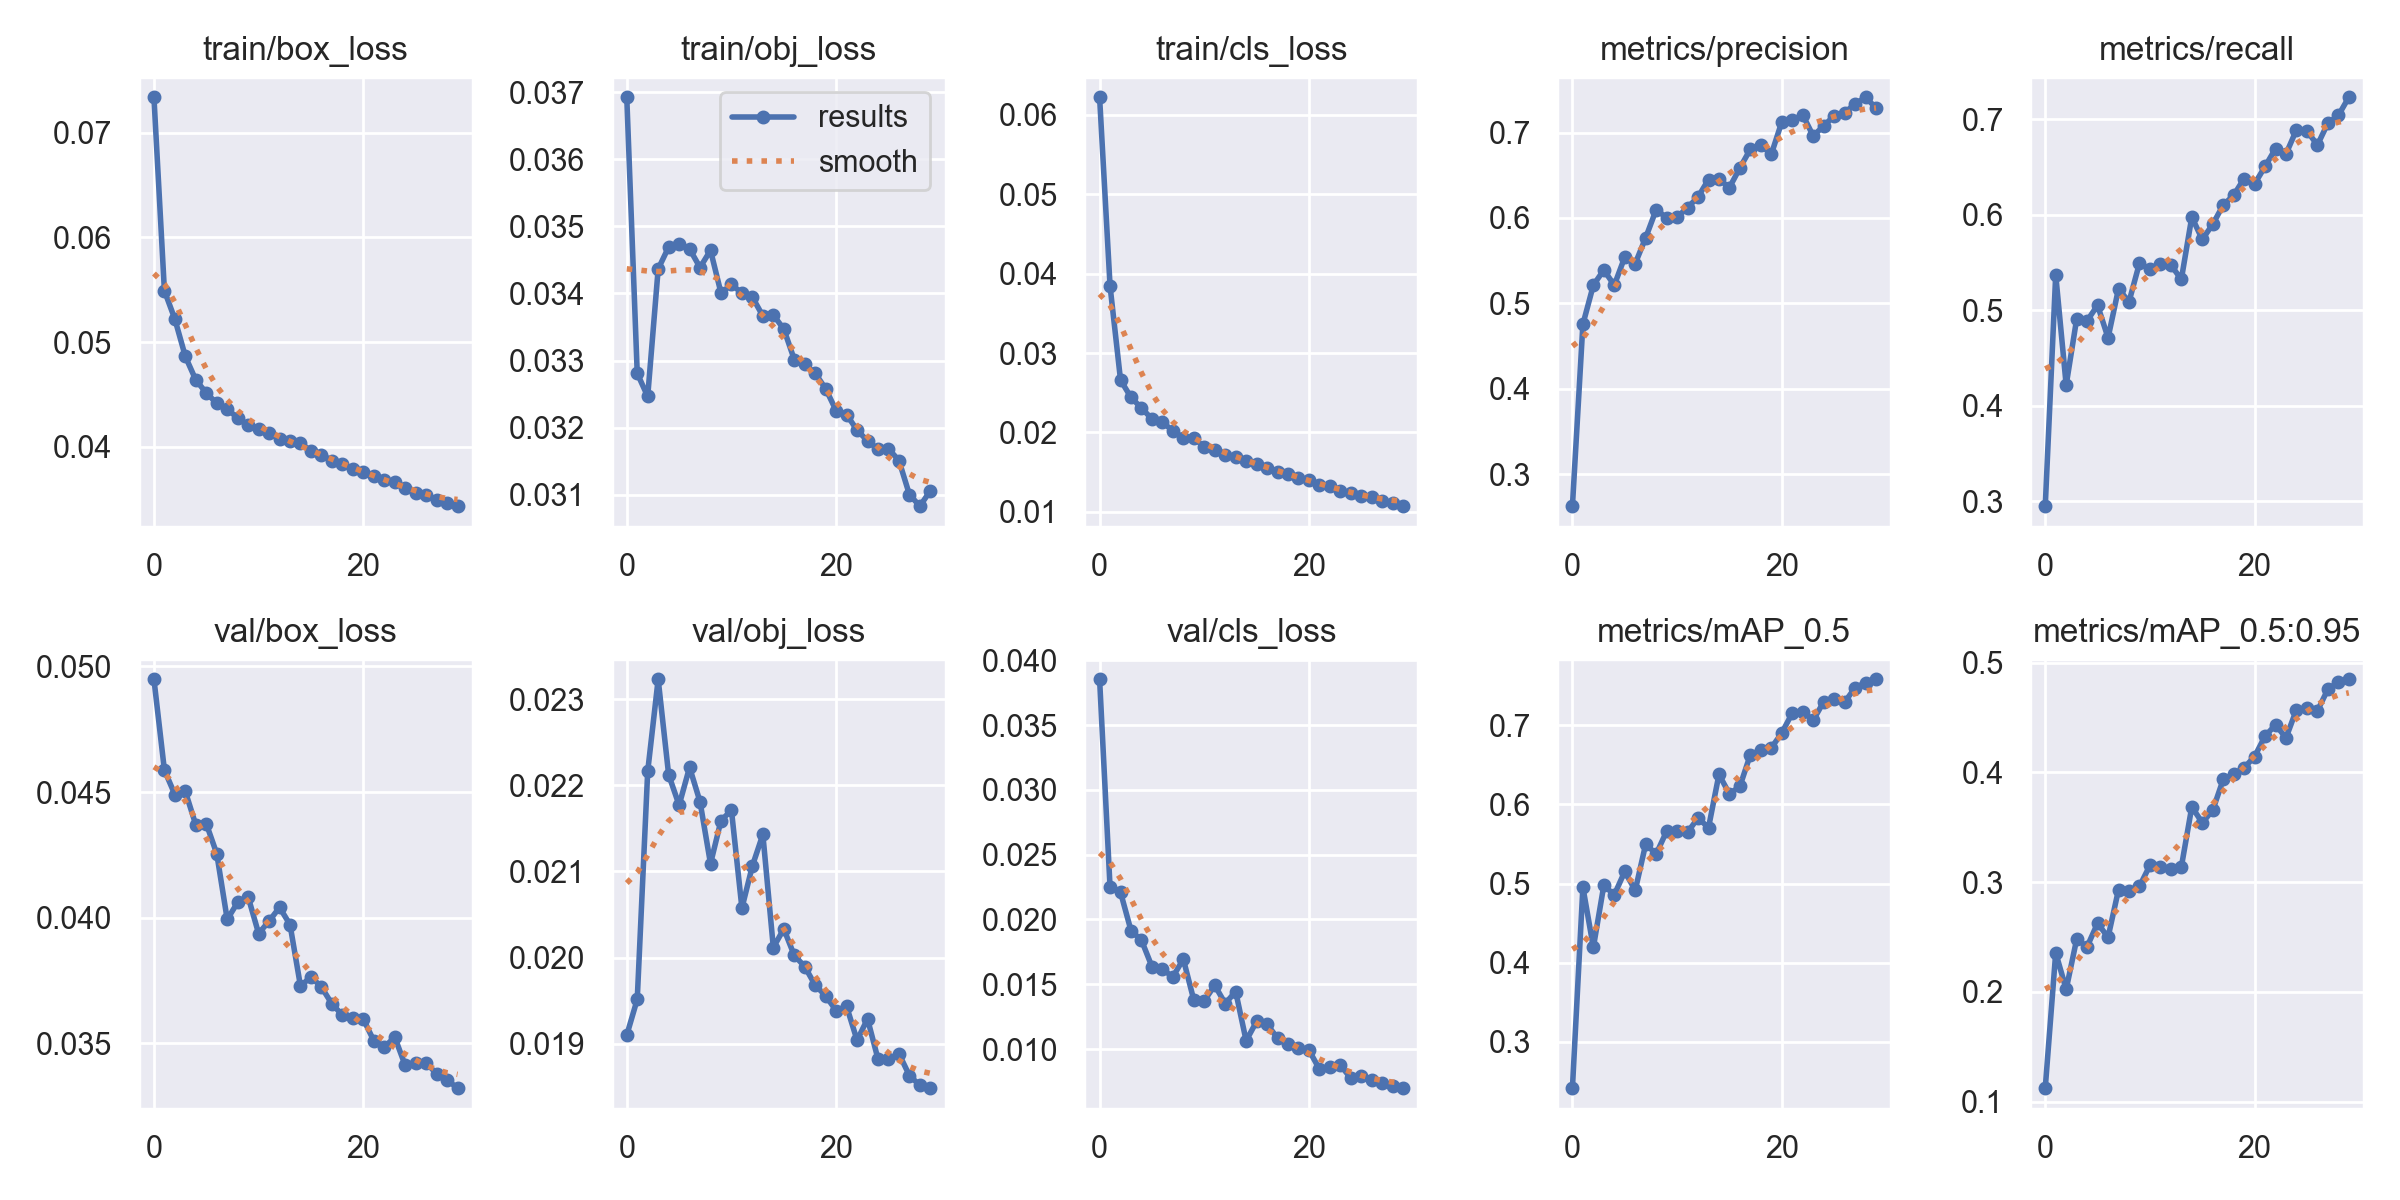

In [56]:
Image(filename = 'runs/train/VOC_hyp/results.png')

Good News! The model performed slightly better, mAP_0.5:0.95 increase from 0.459 to 0.485, and of course, if we give more epochs to run, the model will continue to achieve a better score.

Let's take a look over the curves on validation.

In [5]:
!python val.py --weights runs/train/VOC_default/weights/best.pt --data VOC.yaml --batch-size 128 --workers 1 --name VOC_hyp

val: data=C:\Users\amaris-admin\Documents\yolov5\data\VOC.yaml, weights=['runs/train/VOC_default/weights/best.pt'], batch_size=128, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=1, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name=VOC_hyp, exist_ok=False, half=False, dnn=False
YOLOv5  v7.0-296-gae4ef3b2 Python-3.10.14 torch-2.0.0 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16379MiB)

Fusing layers... 
YOLOv5n summary: 157 layers, 1786225 parameters, 0 gradients, 4.2 GFLOPs

val: Scanning C:\Users\amaris-admin\Documents\datasets\VOC\labels\test2007.cache... 4952 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4952/4952 [00:00<?, ?it/s]
val: Scanning C:\Users\amaris-admin\Documents\datasets\VOC\labels\test2007.cache... 4952 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4952/4952 [00:00<?, ?it/s]

                 Class     Images  Instances          P          R

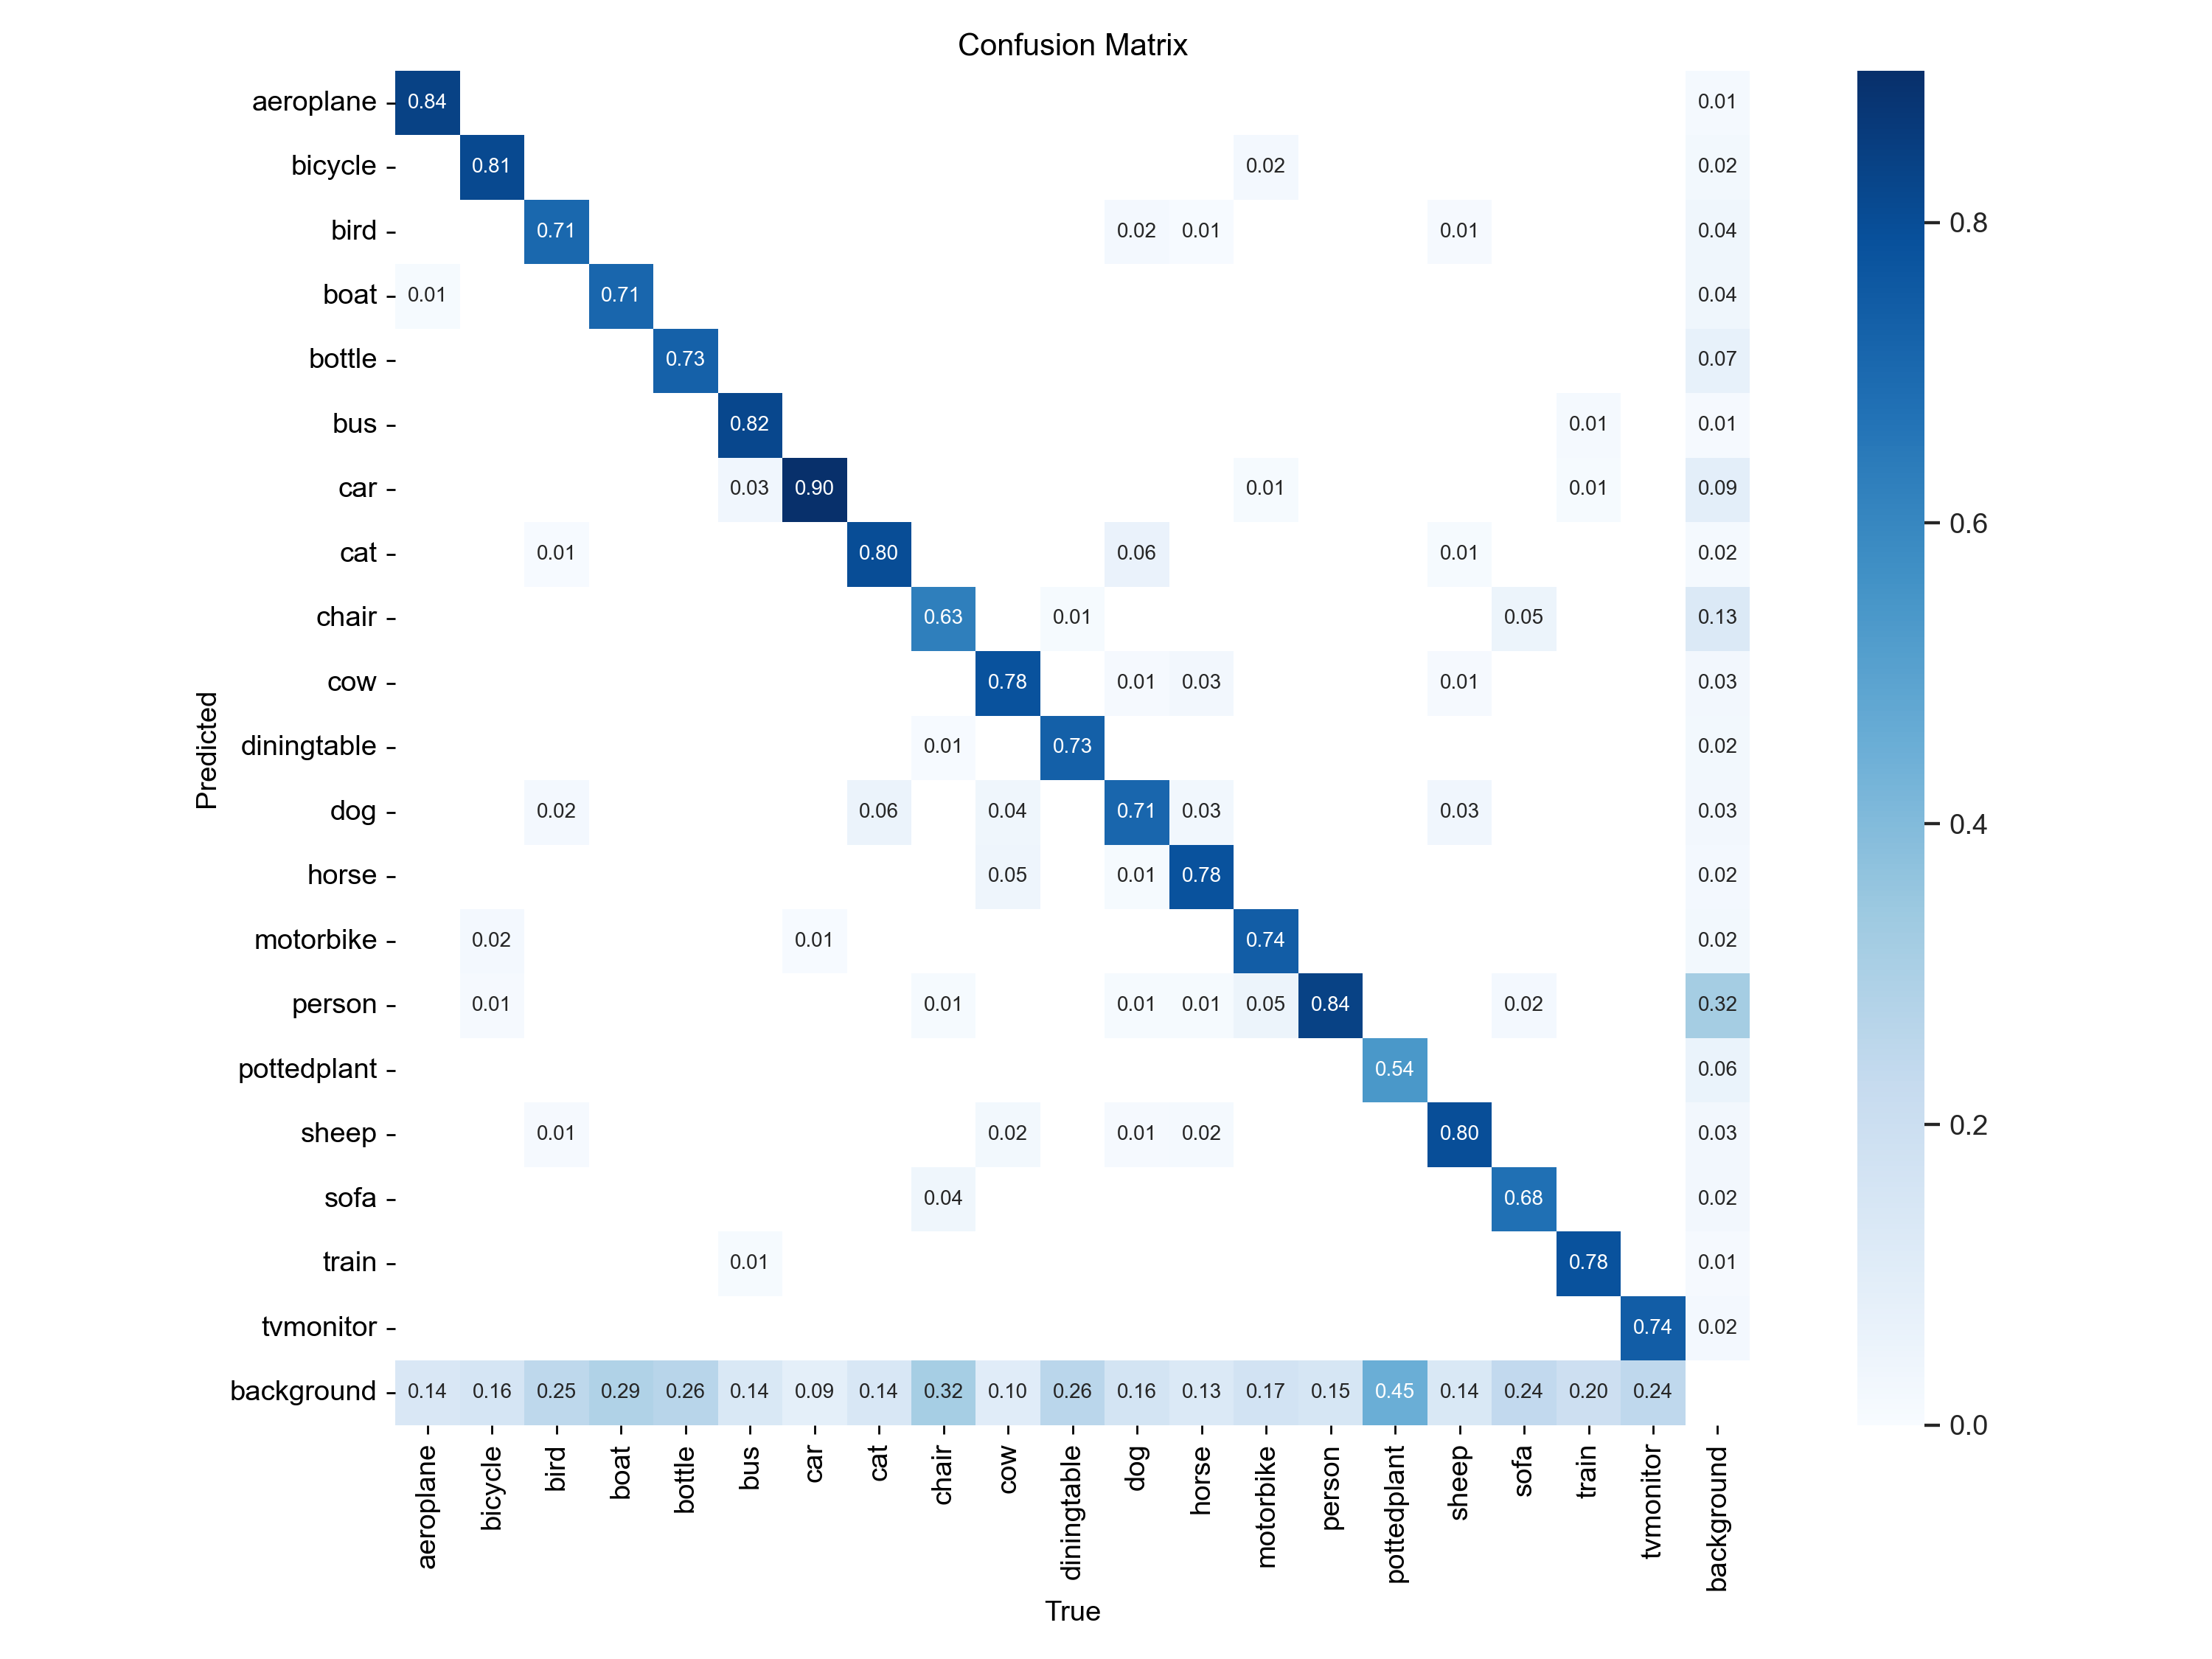

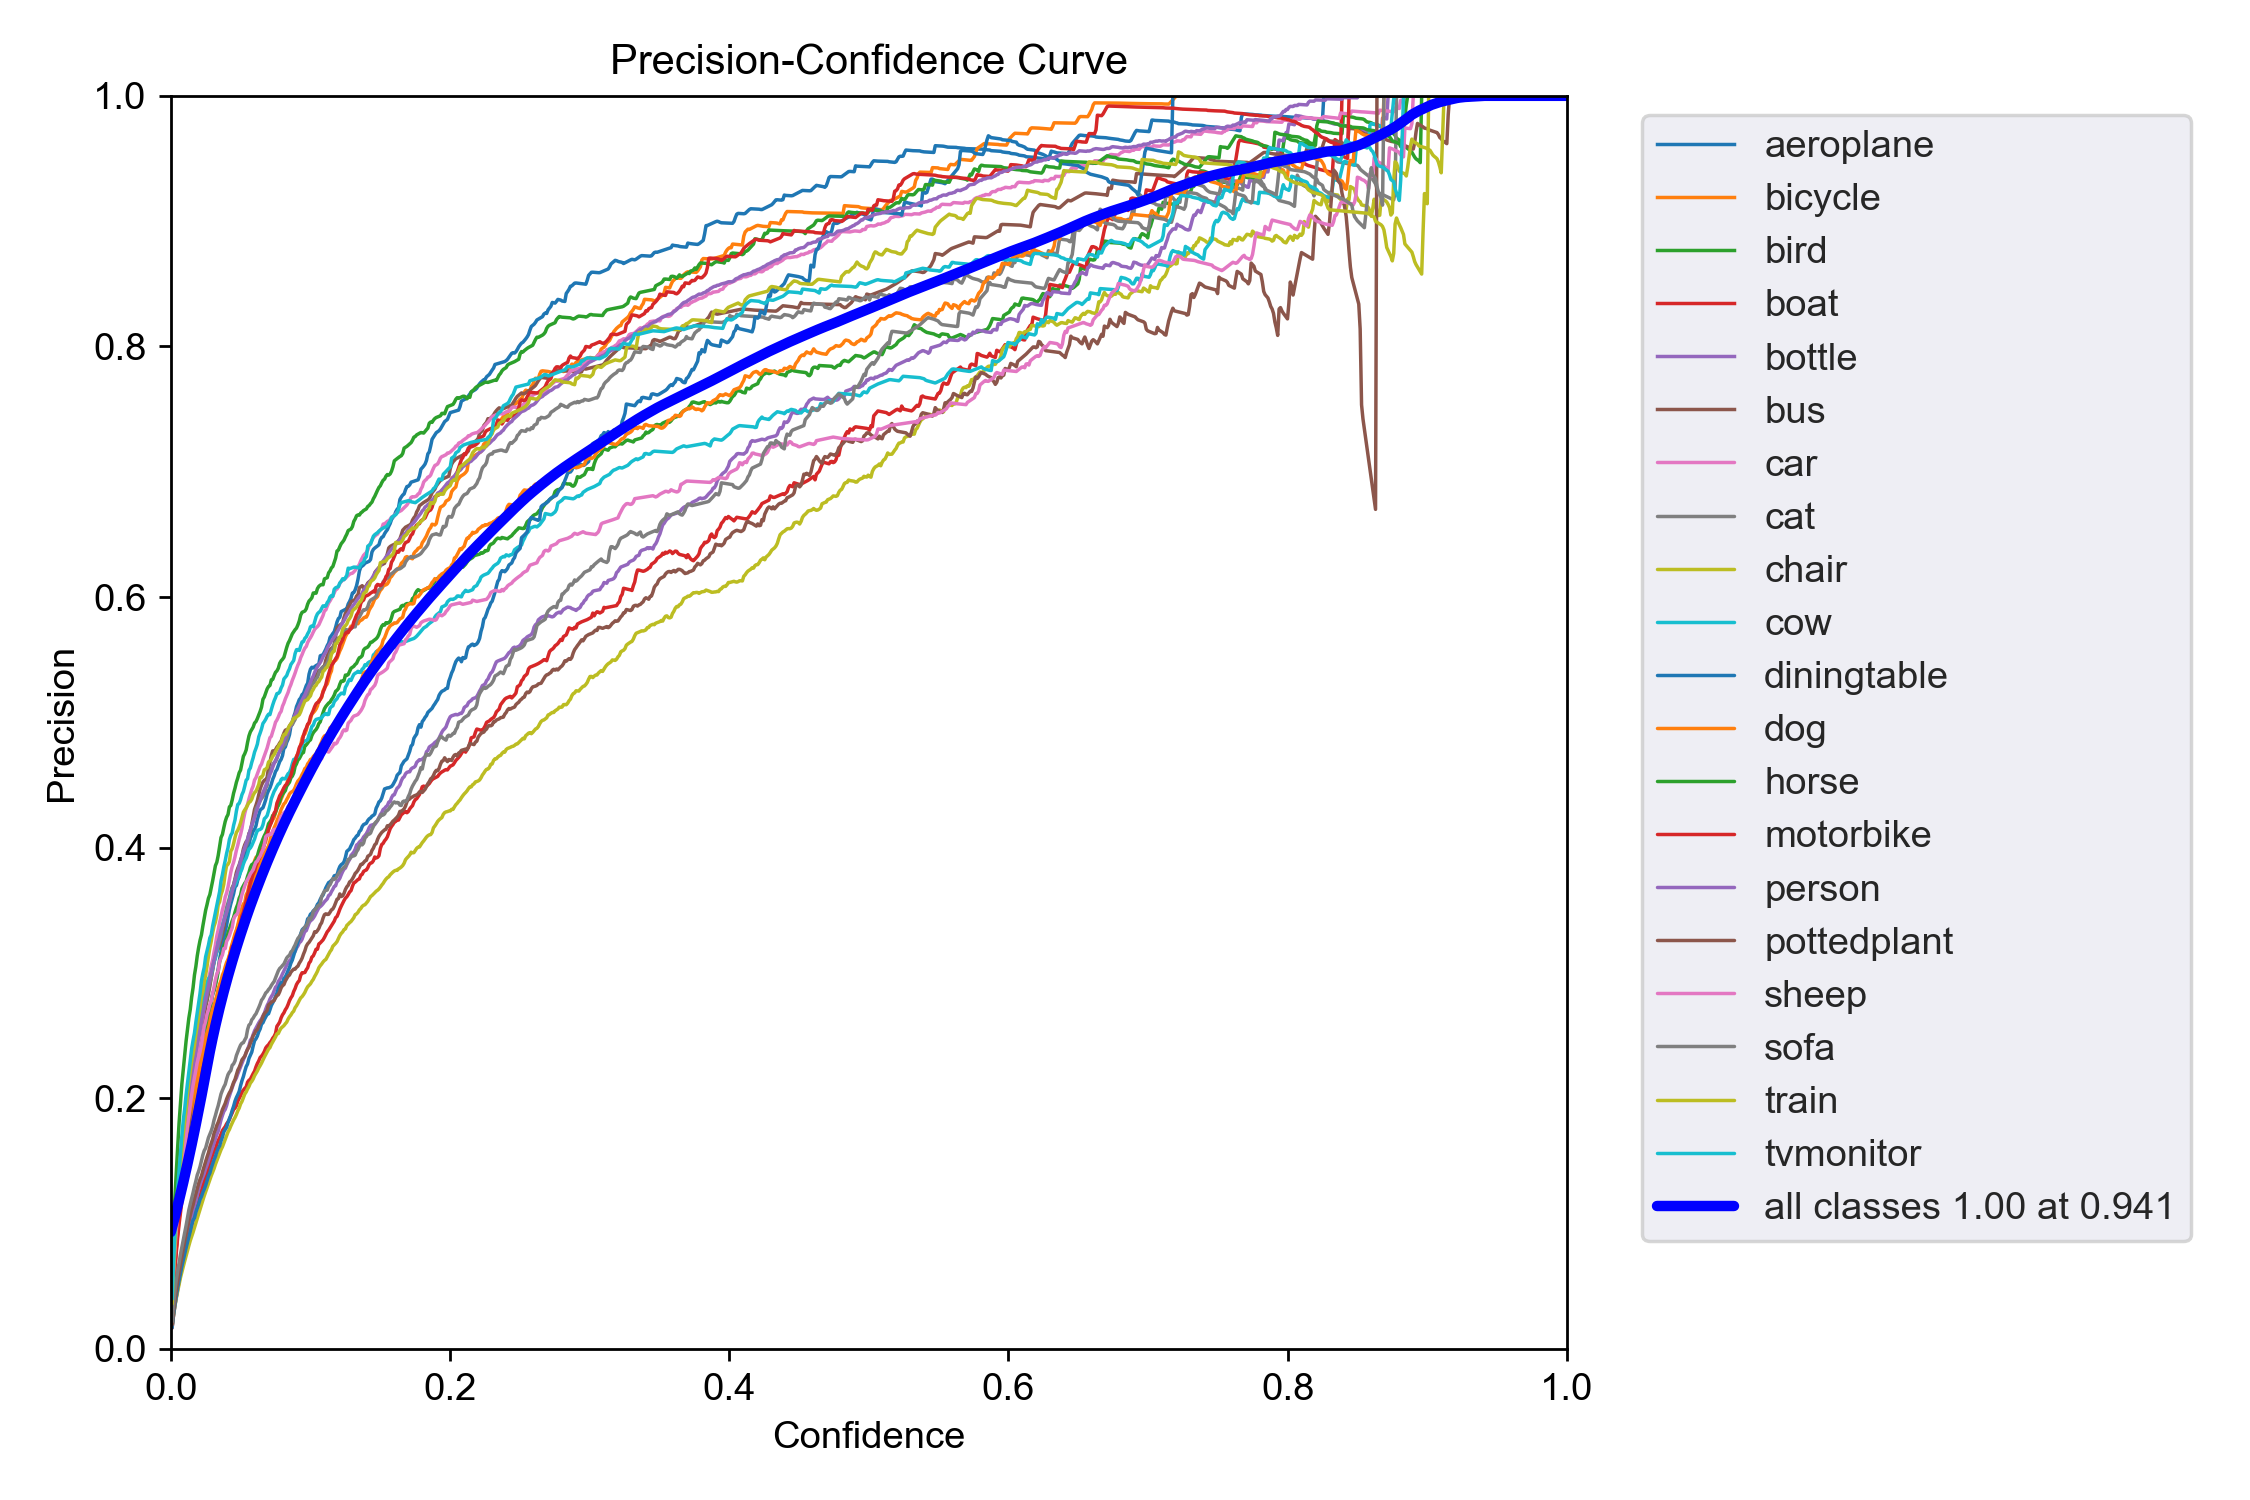

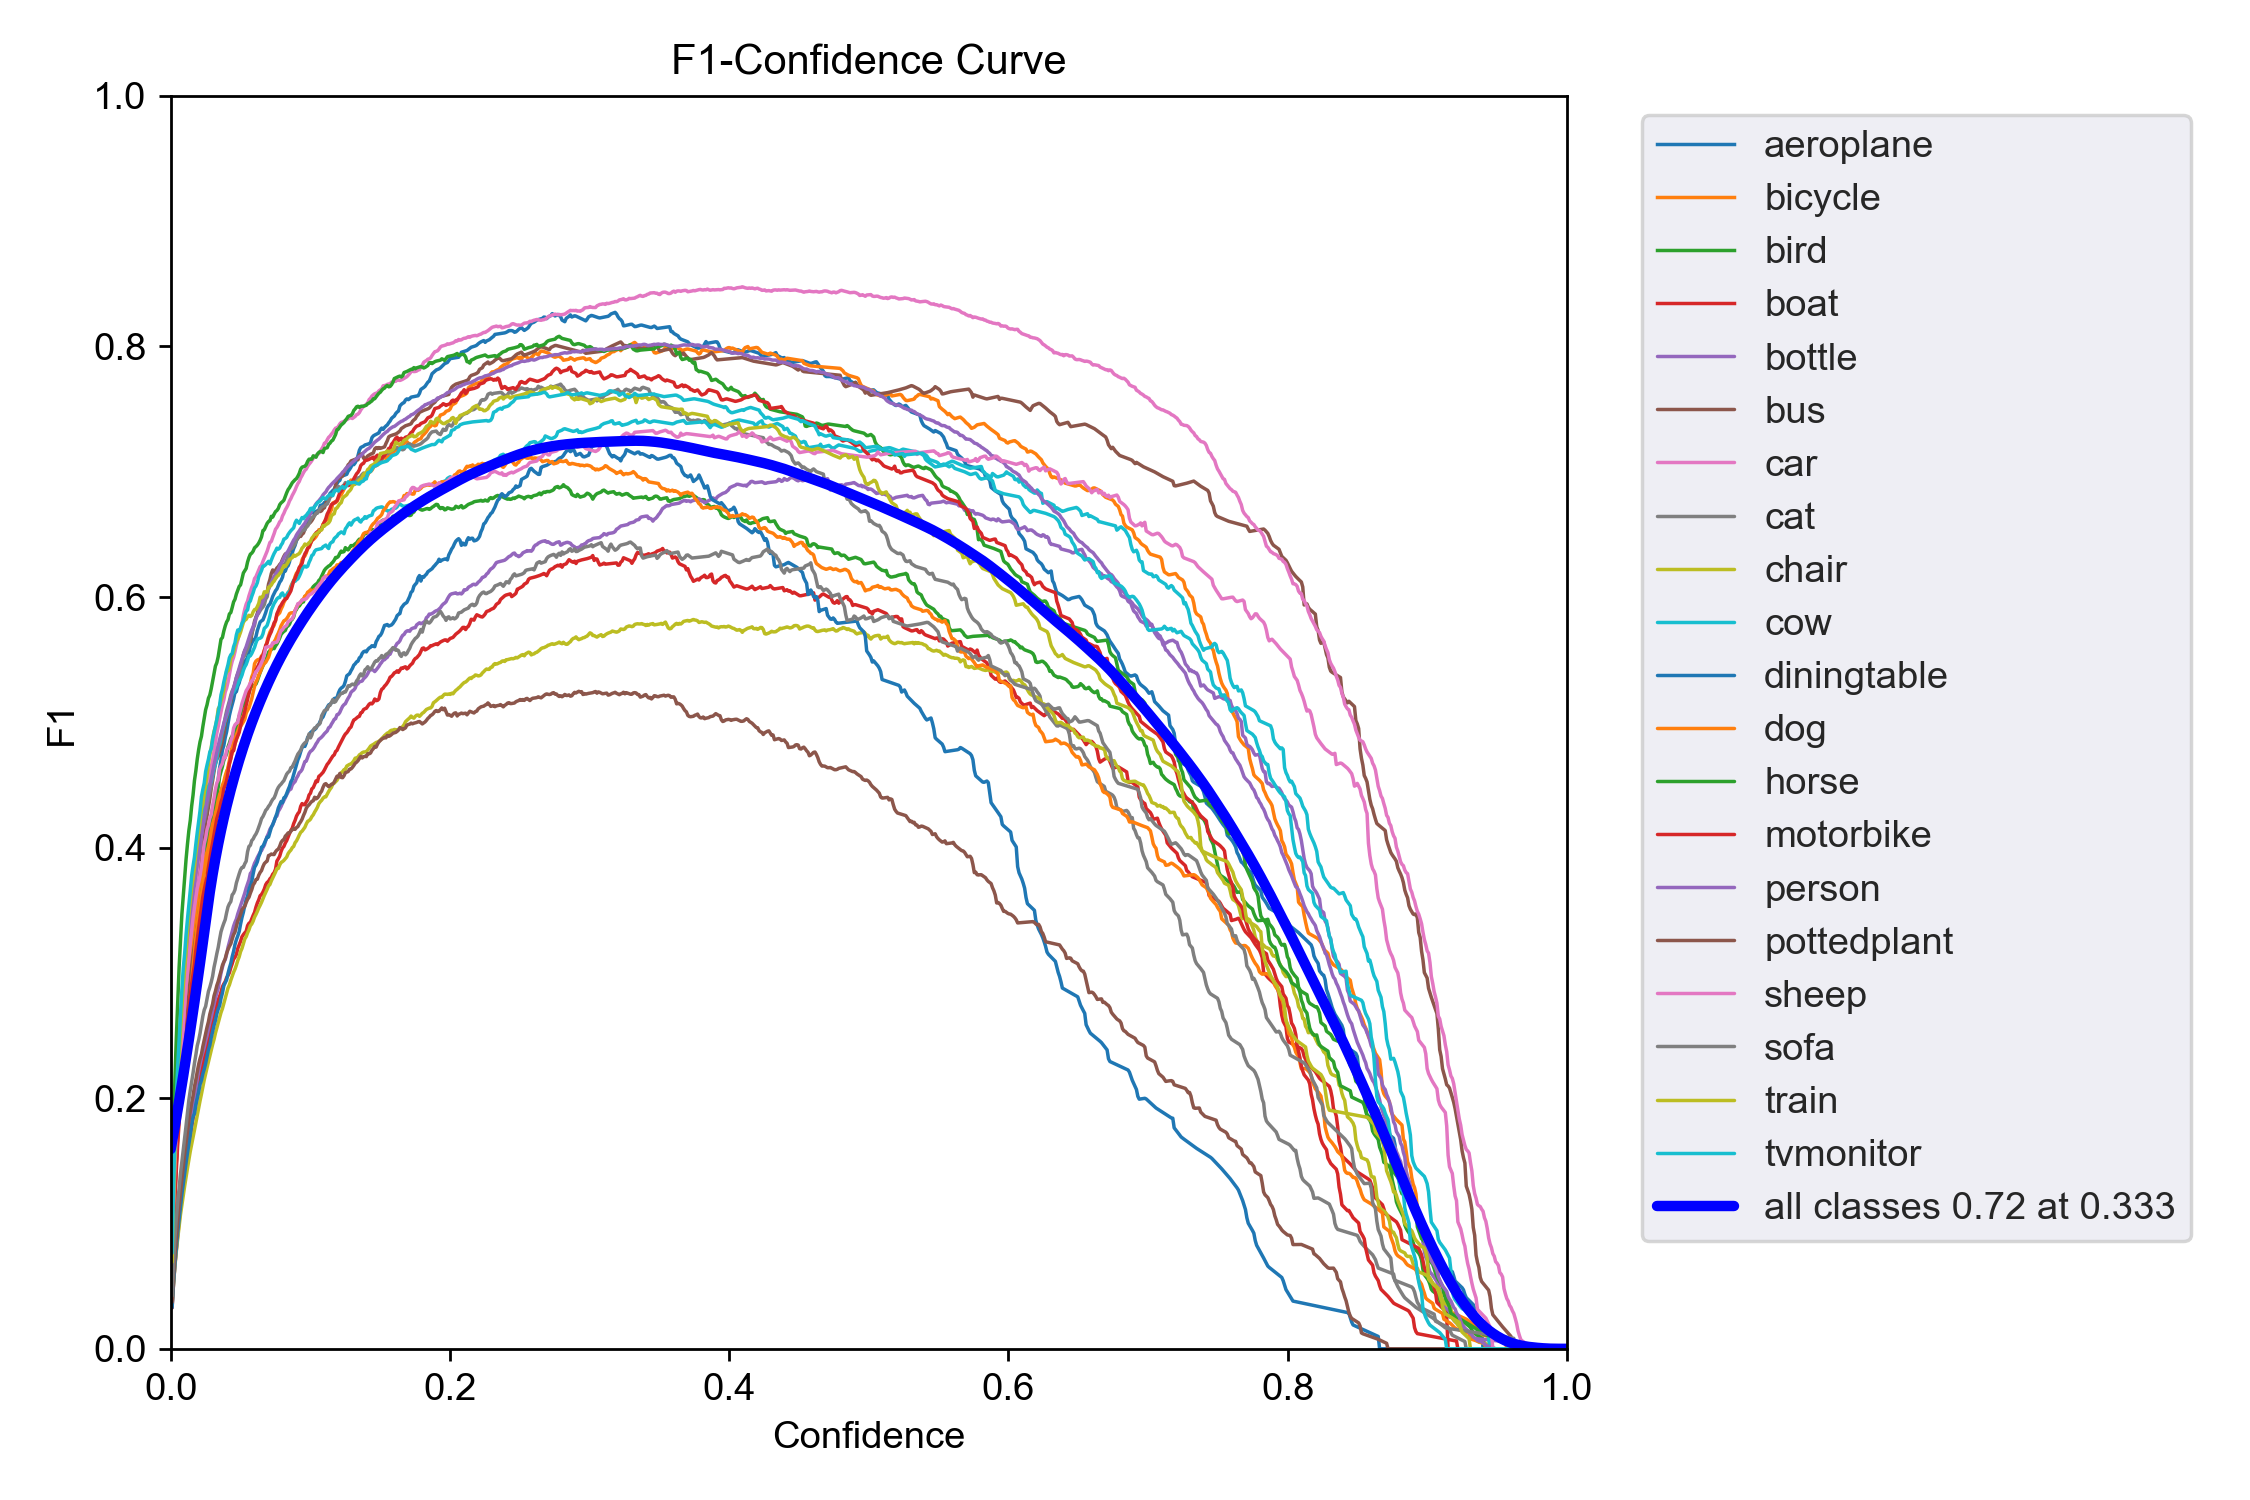

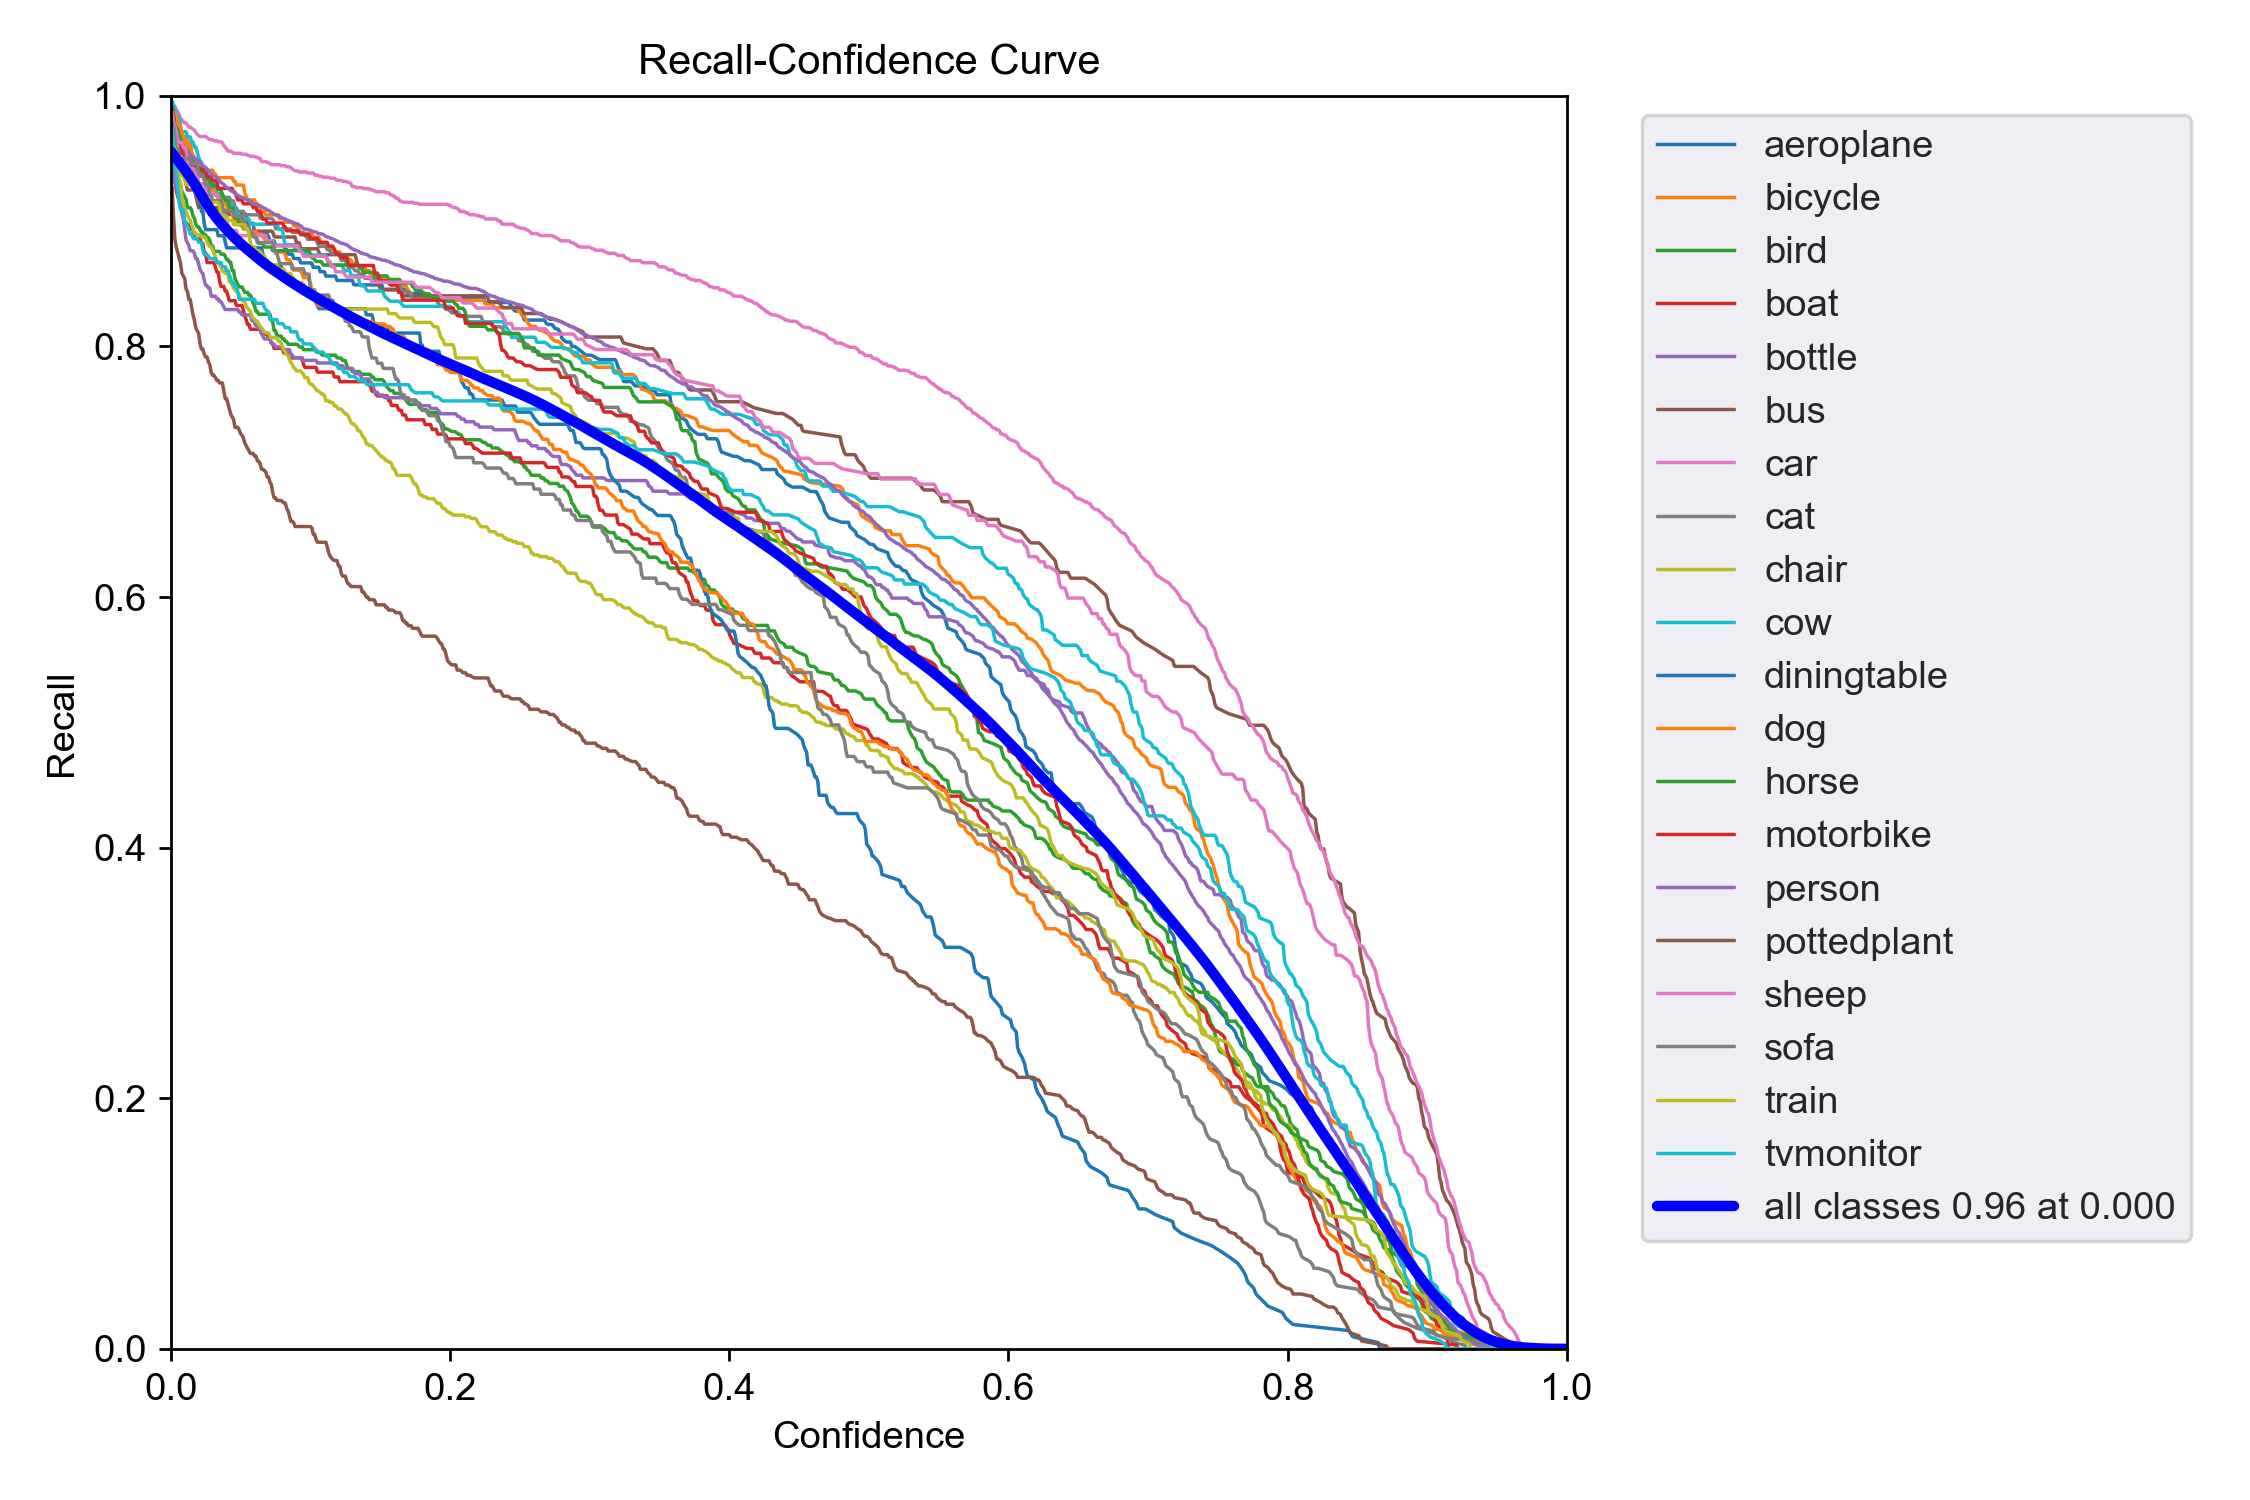

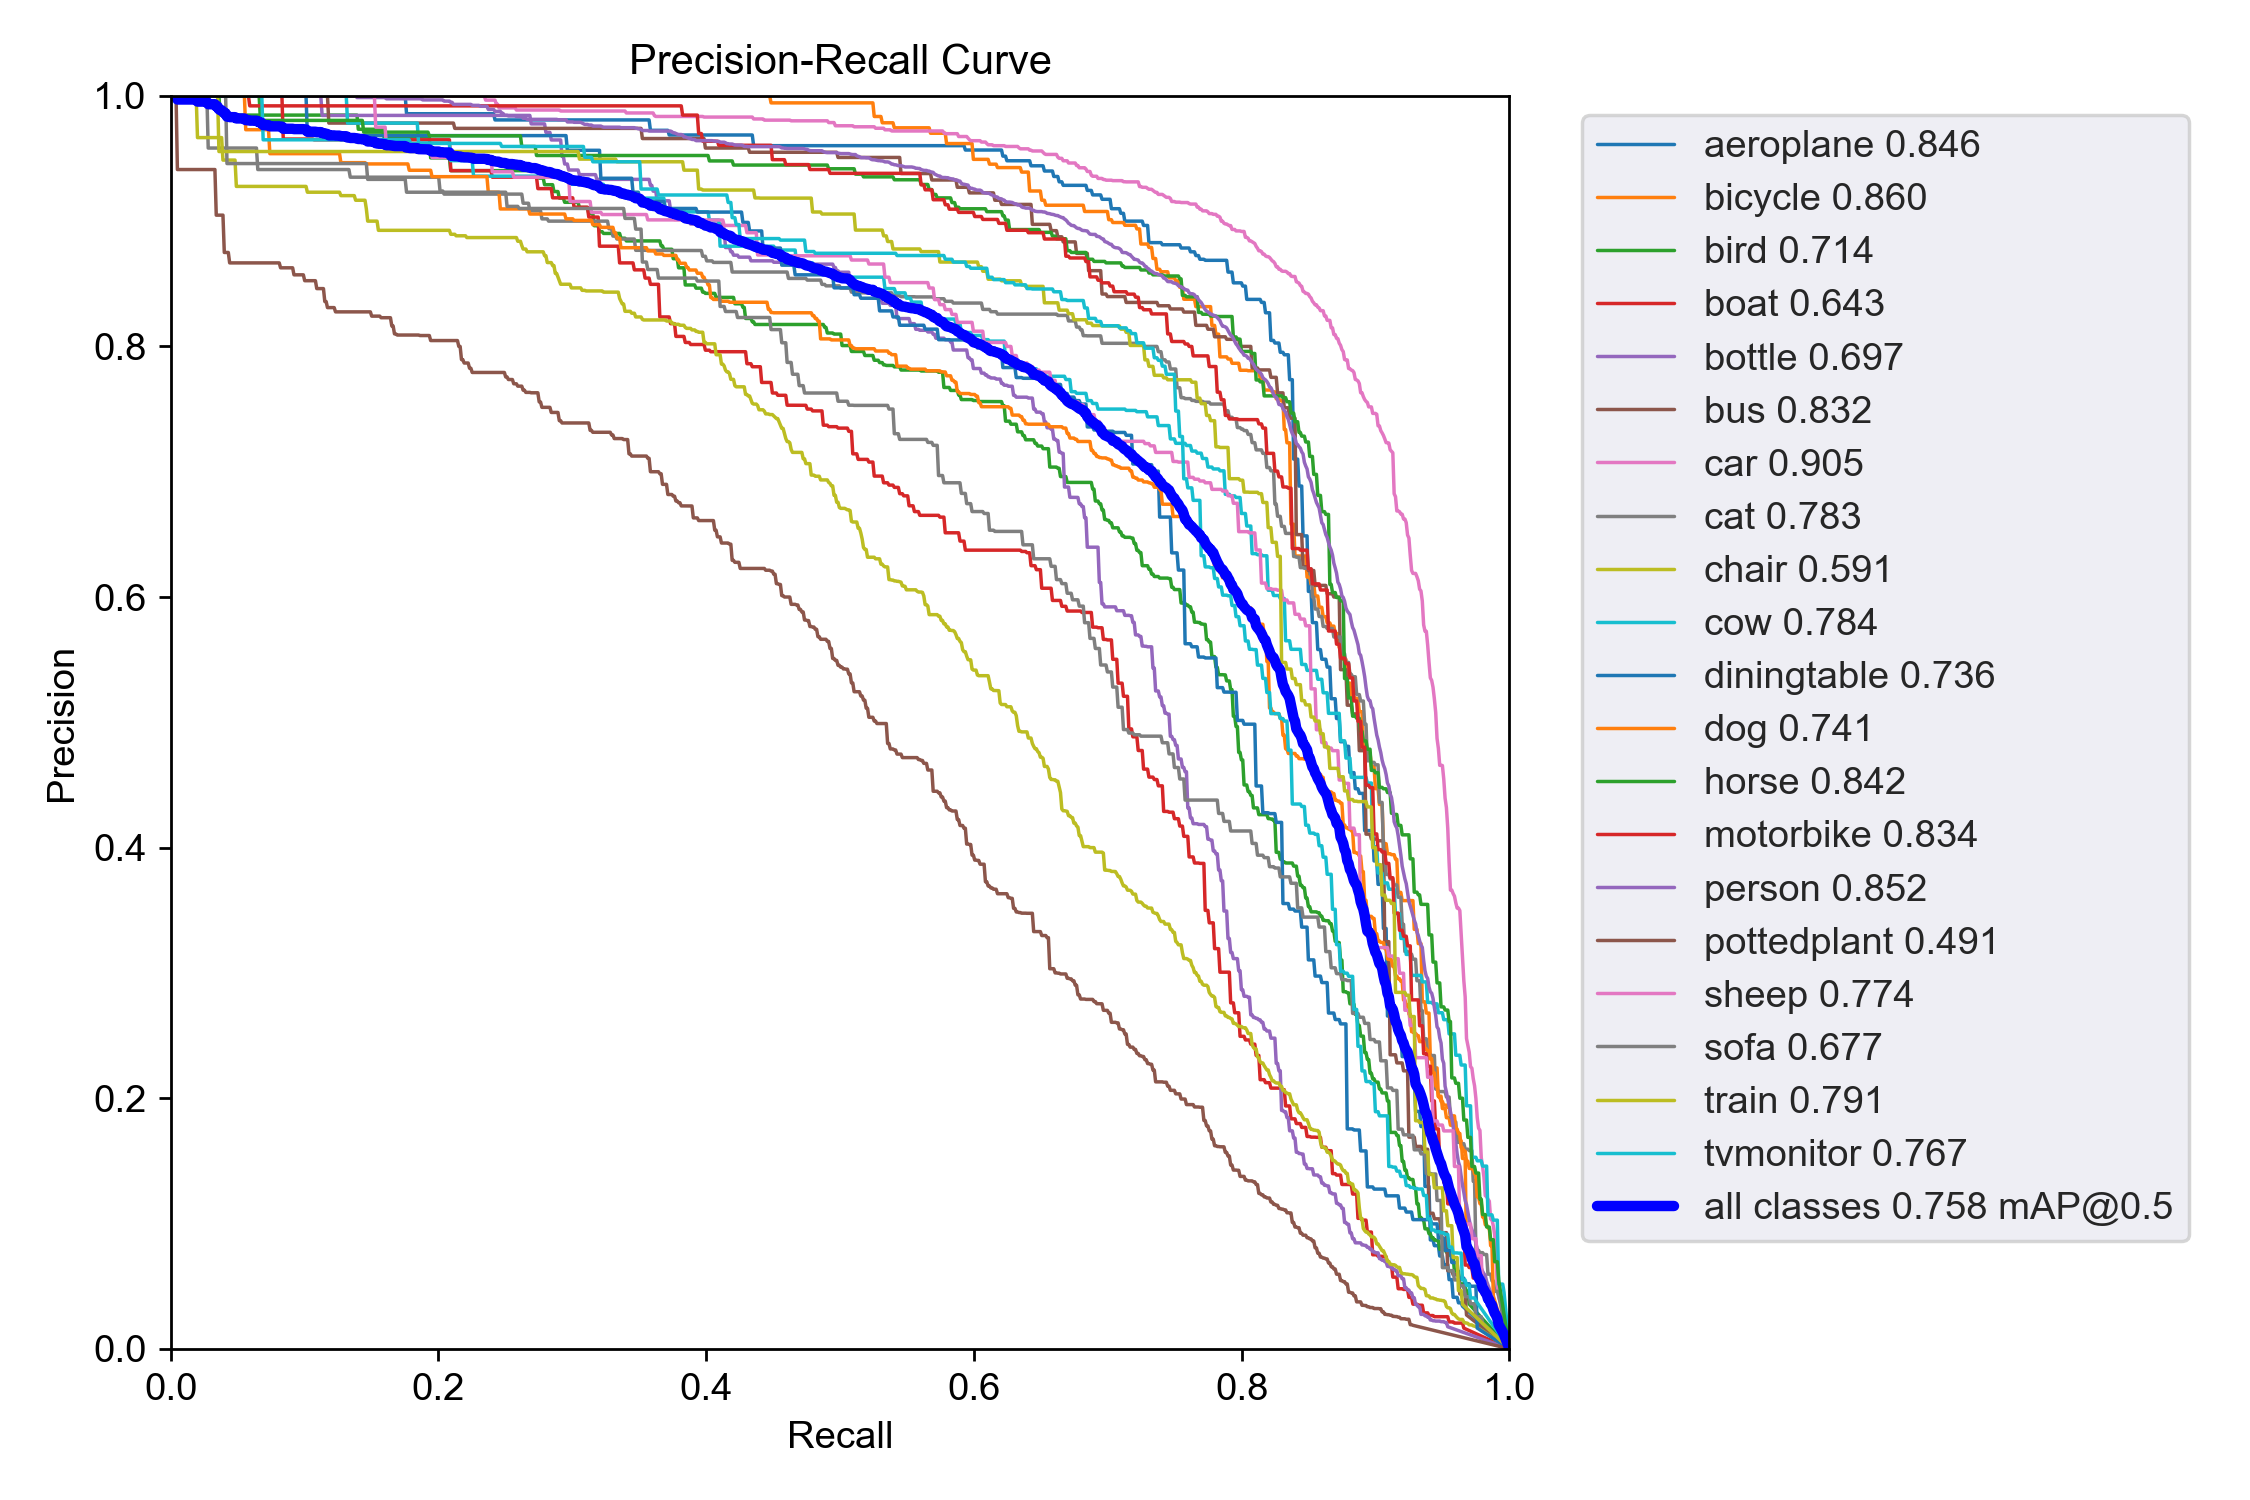

In [57]:
current_directory = os.getcwd()
val_directory = 'runs/val/VOC_hyp'

path = os.path.join(current_directory, val_directory)

# Automatically get all .png files in the directory
png_files = [file for file in os.listdir(path) if file.endswith('.png')]

# Display each image
for image in png_files:
    display(Image(filename=os.path.join(path, image)))